# 1. Objective

- Mengembangkan Model Prophet Forecasting lebih baik dengan menambahkan variable lngkungan seperti 'temperature', 'humidity', and 'WaterTemp'
- Optimalisasi model dengan menerapkan K-Fold untuk validator

# 2. Preparation Package

## 2.1 Imort Package

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import joblib
import os

## 2.2 Data Preparation

In [ ]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

print("Banyak data train", len(df_train))
print("Banyak data test", len(df_test))

Banyak data train 5283
Banyak data test 3023


In [ ]:
df_train.head()

,day,hole,time,temperature,humidity,light,pH,EC,TDS,WaterTemp,LeafCount
datetime,,,,,,,,,,,
2024-07-01 08:55:00,1,1,08:55:00,25.3,92,21910,7.0,660,330,23.1,3
2024-07-01 08:57:00,1,2,08:57:00,25.3,92,21910,7.0,660,330,23.1,3
2024-07-01 08:59:00,1,3,08:59:00,25.5,92,21060,7.8,984,492,26.1,3
2024-07-01 08:59:00,1,3,08:59:00,25.5,92,21060,7.0,652,326,23.1,4
2024-07-01 09:02:00,1,4,09:02:00,25.7,92,28330,7.0,656,328,23.1,3


In [ ]:
# Calculate and print the total number of unique days in the dataset
total_days = df_train.index.date.max() - df_train.index.date.min()
print(f'Total days in the training dataset: {total_days.days + 1}')  # Adding 1 to include the start day in the count

Total days in the training dataset: 40


In [ ]:
# Calculate and print the total number of unique days in the dataset
total_days_test = df_test.index.date.max() - df_test.index.date.min()
print(f'Total days in the test dataset: {total_days_test.days + 1}')  # Adding 1 to include the start day in the count

Total days in the test dataset: 40


# 3. Modeling & Evaluation

## 3.1 Prophet Base Model

In [ ]:
# Prepare the training data for Prophet
df_train = df_train.reset_index()  # Reset the index for Prophet compatibility
df_train = df_train.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})

# Prepare the test data for evaluation
df_test = df_test.reset_index()
df_test = df_test.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})

In [ ]:
# Add a cap for logistic growth
df_train['cap'] = 18  # Maximum value for LeafCount (lettuce growth limit)

# Add the cap to the testing data
df_test['cap'] = 18  # Ensure the cap is consistent with training data

In [ ]:
# Initialize the Prophet model
model = Prophet(growth="logistic")  # Specify logistic growth
model.add_regressor('temperature')
model.add_regressor('humidity')
model.add_regressor('WaterTemp')

# Fit the model on training data
model.fit(df_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48q3hgdx/zbws9pkx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48q3hgdx/jt22kh6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59513', 'data', 'file=/tmp/tmp48q3hgdx/zbws9pkx.json', 'init=/tmp/tmp48q3hgdx/jt22kh6p.json', 'output', 'file=/tmp/tmp48q3hgdx/prophet_model8mxzu2u3/prophet_model-20241217104817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:48:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:48:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Ensure testing data contains the required regressors
future = df_test.copy()

# Make predictions
forecast = model.predict(future)

# Combine predictions with actuals for evaluation
df_test['yhat'] = forecast['yhat']
df_test['yhat_lower'] = forecast['yhat_lower']
df_test['yhat_upper'] = forecast['yhat_upper']

In [ ]:
# Include the additional columns in the output
output = df_test[['ds', 'y', 'temperature', 'humidity', 'WaterTemp', 'yhat', 'yhat_lower', 'yhat_upper']]

# Print the output
print(output)

                      ds   y  temperature  humidity  WaterTemp       yhat  \
0    2024-07-01 09:19:00   3         26.8        72       26.1   3.427304   
1    2024-07-01 09:23:00   3         26.6        72       26.1   3.425030   
2    2024-07-01 09:27:00   3         26.4        72       26.1   3.422326   
3    2024-07-01 09:28:00   3         26.8        72       26.1   3.431807   
4    2024-07-01 09:29:00   4         26.9        72       26.1   3.434450   
...                  ...  ..          ...       ...        ...        ...   
3018 2024-08-09 16:43:00  10         27.2        57       25.3  15.868245   
3019 2024-08-09 16:44:00  16         25.6        44       30.1  15.609135   
3020 2024-08-09 16:44:00  17         27.6        57       25.3  15.880360   
3021 2024-08-09 16:45:00  19         25.4        44       30.1  15.607657   
3022 2024-08-09 16:45:00  15         27.6        57       25.3  15.883425   

      yhat_lower  yhat_upper  
0       1.235399    5.656374  
1       1.203

In [ ]:
# Calculate evaluation metrics
rmse_prophet = np.sqrt(mean_squared_error(output['y'], output['yhat']))
mae_prophet = mean_absolute_error(output['y'], output['yhat'])

# Display evaluation results
print(f"RMSE: {rmse_prophet}")
print(f"MAE: {mae_prophet}")

RMSE: 1.8024601856517313
MAE: 1.3722544463287507


In [ ]:
# Convert necessary columns to numeric, if not already
output[['y', 'yhat', 'yhat_lower', 'yhat_upper']] = output[['y', 'yhat', 'yhat_lower', 'yhat_upper']].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaNs in key columns
output = output.dropna(subset=['y', 'yhat', 'yhat_lower', 'yhat_upper'])

<ipython-input-66-57790c8267b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output[['y', 'yhat', 'yhat_lower', 'yhat_upper']] = output[['y', 'yhat', 'yhat_lower', 'yhat_upper']].apply(pd.to_numeric, errors='coerce')


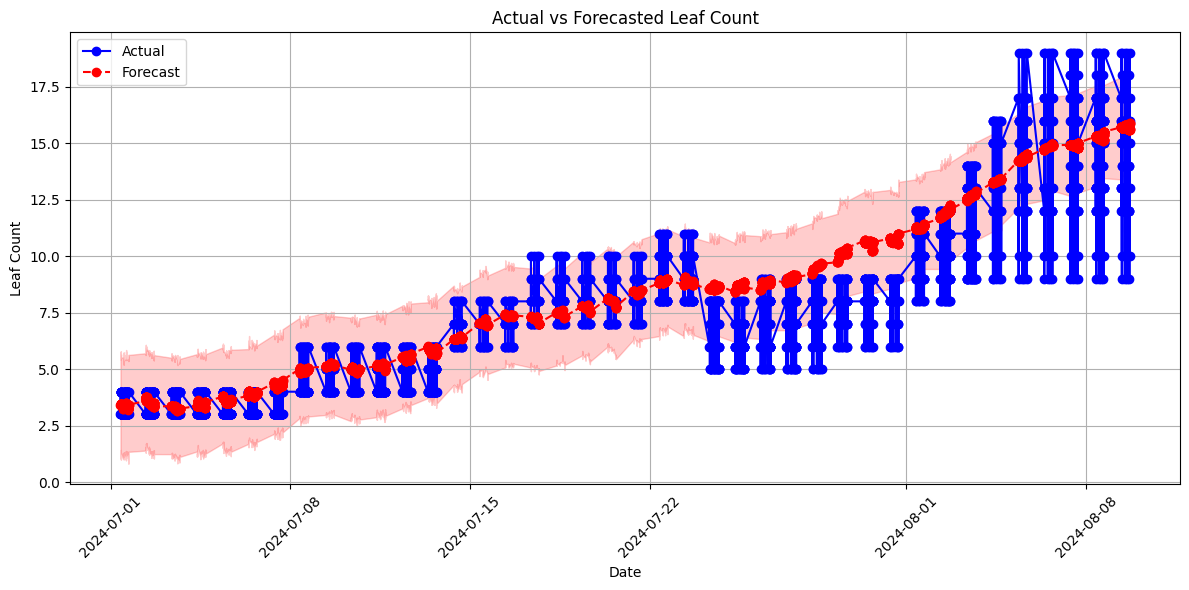

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(output['ds'], output['y'], marker='o', linestyle='-', color='blue', label='Actual')

# Plot forecasted values
plt.plot(output['ds'], output['yhat'], marker='o', linestyle='--', color='red', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(output['ds'], output['yhat_lower'], output['yhat_upper'], color='red', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Resample df_test to group by days (ensuring 40 unique days)
# Exclude 'time' column from the resampling and mean calculation
df_test_daily = df_test.drop(columns=['time']).resample('D').mean().reset_index()

df_test_daily = df_test_daily.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
df_test_daily['cap'] = 18  # Add cap for logistic growth

# Ensure there are 40 days in the grouped data
print(f"Total unique days: {df_test_daily['ds'].nunique()}")

Total unique days: 40


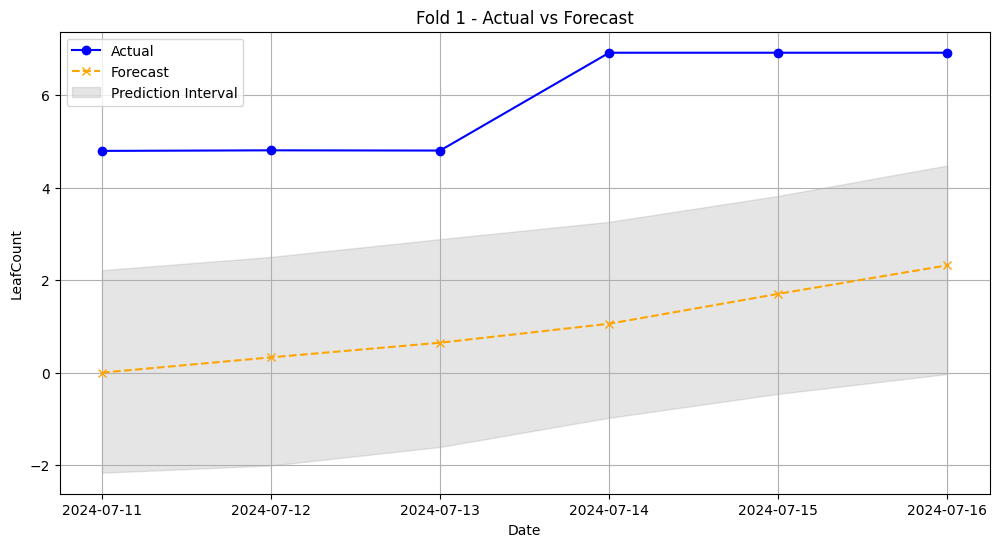

Fold 1 RMSE: 4.886592821815167


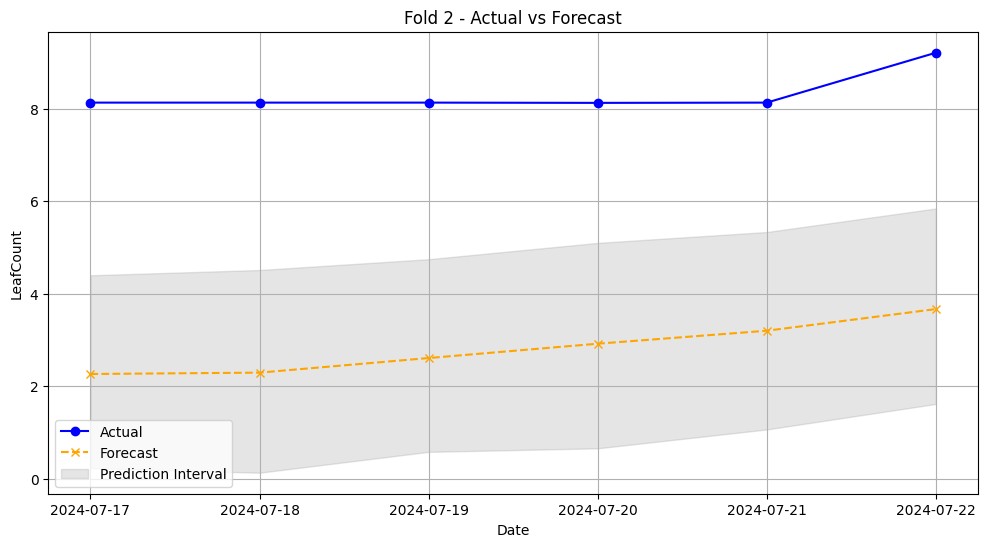

Fold 2 RMSE: 5.4903595139396595


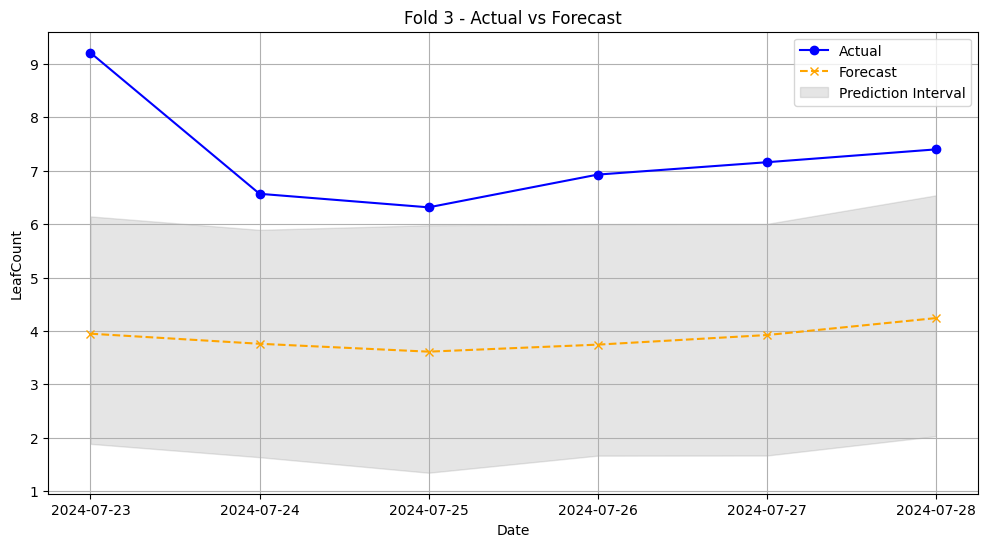

Fold 3 RMSE: 3.5000160109654503


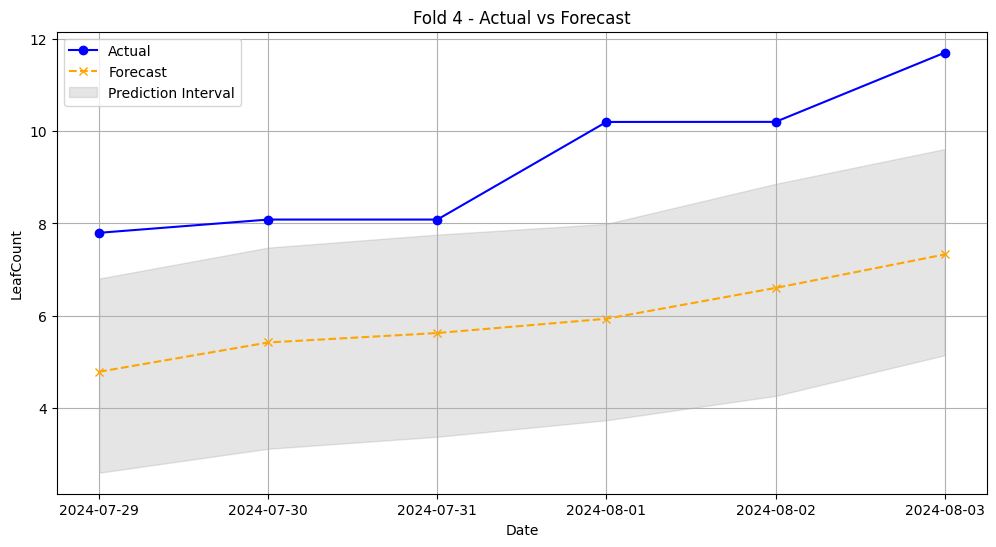

Fold 4 RMSE: 3.4752470153209334


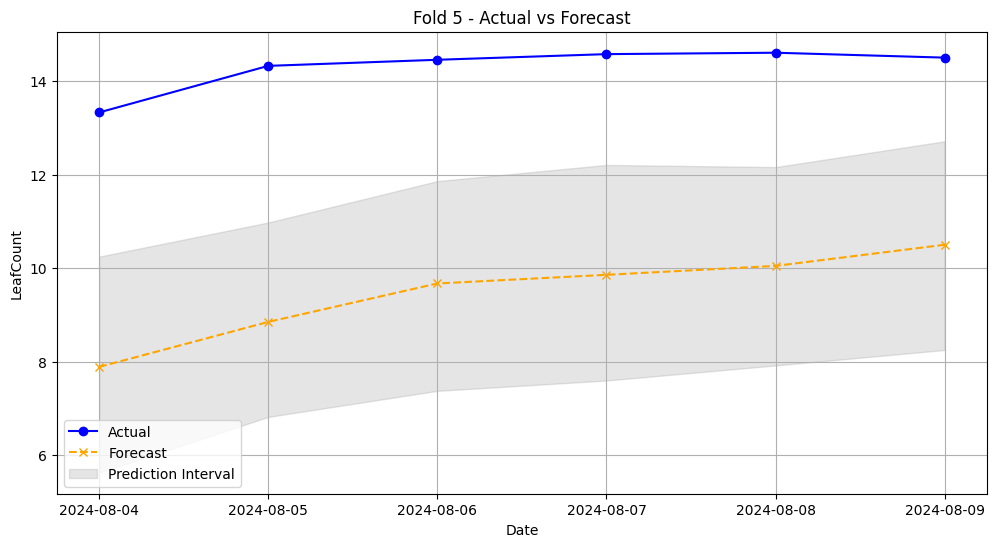

Fold 5 RMSE: 4.856726686551366
K-Fold Results:
   fold      rmse
0     1  4.886593
1     2  5.490360
2     3  3.500016
3     4  3.475247
4     5  4.856727
Mean RMSE across folds: 4.441788409718514


In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store fold results
fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_test_daily)):
    # Use model for predictions
    train_data = df_test_daily.iloc[train_idx]
    val_data = df_test_daily.iloc[val_idx]

    # Prepare validation data for predictions, including regressors
    val_data_future = val_data[['ds', 'cap', 'temperature', 'humidity', 'WaterTemp']]
    forecast = model.predict(val_data_future)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
    fold_results.append({'fold': fold + 1, 'rmse': rmse})

    # Visualization for the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(val_data['ds'], val_data['y'], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x', linestyle='--', color='orange')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='gray',
        alpha=0.2,
        label='Prediction Interval'
    )
    plt.xlabel('Date')
    plt.ylabel('LeafCount')
    plt.title(f'Fold {fold + 1} - Actual vs Forecast')
    plt.legend()
    plt.grid()
    plt.show()

    # Print RMSE for the fold
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Compile all fold results
kfold_results = pd.DataFrame(fold_results)

# Print overall results
print("K-Fold Results:")
print(kfold_results)

# Calculate and print mean RMSE across all folds
mean_rmse = kfold_results['rmse'].mean()
print(f"Mean RMSE across folds: {mean_rmse}")

In [ ]:
# Resampling to calculate daily means
output_daily = output.set_index('ds').resample('D').mean().reset_index()

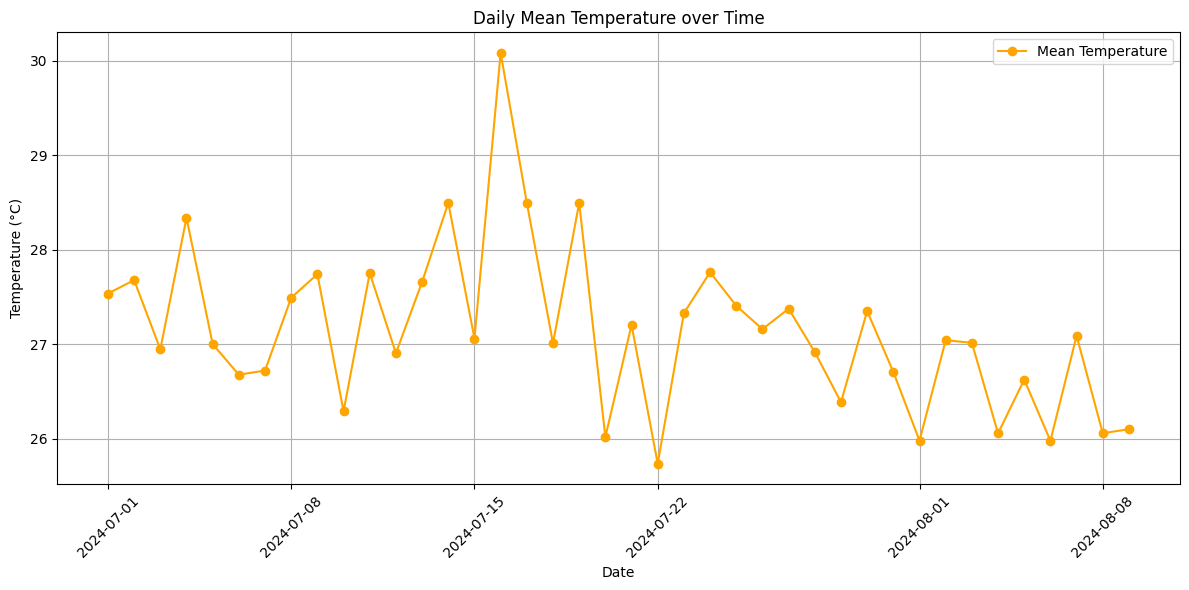

In [ ]:
# Plot Temperature (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(output_daily['ds'], output_daily['temperature'], marker='o', linestyle='-', color='orange', label='Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Mean Temperature over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

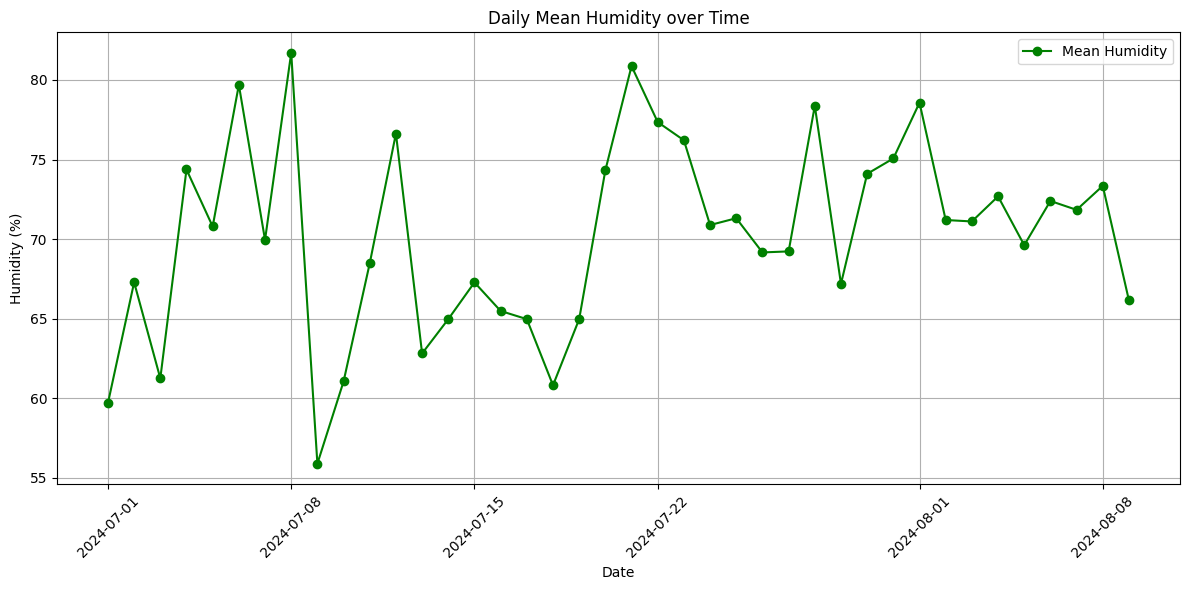

In [ ]:
# Plot Humidity (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(output_daily['ds'], output_daily['humidity'], marker='o', linestyle='-', color='green', label='Mean Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Daily Mean Humidity over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

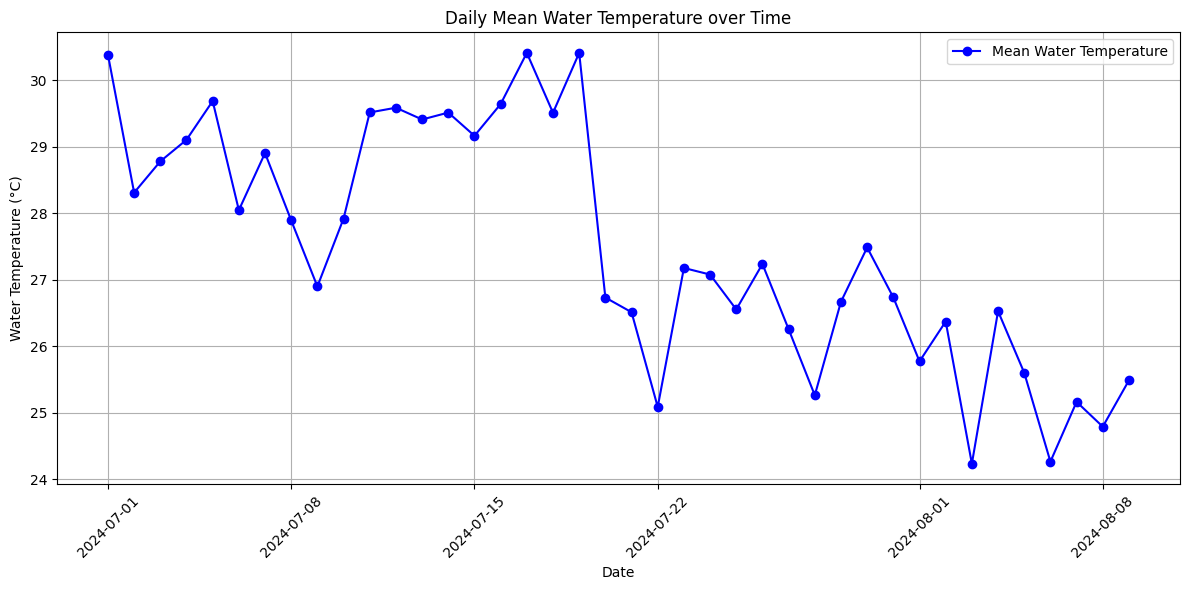

In [ ]:
# Plot Water Temperature (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(output_daily['ds'], output_daily['WaterTemp'], marker='o', linestyle='-', color='blue', label='Mean Water Temperature')
plt.xlabel('Date')
plt.ylabel('Water Temperature (°C)')
plt.title('Daily Mean Water Temperature over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.2 Prophet Fine-Tunning + KFold

In [ ]:
# Load the datasets
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

# Prepare training data for Prophet
df_train = df_train.reset_index()
df_train = df_train.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})

In [ ]:
# Add a cap for logistic growth
df_train['cap'] = 18  # Maximum value for LeafCount (lettuce growth limit)

# Prepare testing data for evaluation
df_test = df_test.reset_index()
df_test = df_test.rename(columns={'datetime': 'ds'})

# Add the cap to the testing data
df_test['cap'] = 18  # Ensure the cap is consistent with training data

In [ ]:
# Modify the objective function to save K-Fold results in a DataFrame
def objective(trial):
    # Suggest hyperparameters
    changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10.0)
    holidays_prior_scale = trial.suggest_loguniform('holidays_prior_scale', 0.01, 10.0)

    # Perform K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    fold_errors = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
        # Initialize the Prophet model with suggested hyperparameters INSIDE the loop
        model_tuned = Prophet(
            growth='logistic',
            changepoint_prior_scale=changepoint_prior_scale,
            seasonality_prior_scale=seasonality_prior_scale,
            holidays_prior_scale=holidays_prior_scale
        )

        # Add regressors
        model_tuned.add_regressor('temperature')
        model_tuned.add_regressor('humidity')
        model_tuned.add_regressor('WaterTemp')

        train_data = df_train.iloc[train_idx]
        val_data = df_train.iloc[val_idx]

        # Fit the model on training data
        model_tuned.fit(train_data)

        # Prepare future dataframe for validation set
        val_data_future = val_data[['ds', 'temperature', 'humidity', 'WaterTemp', 'cap']]

        # Make predictions
        forecast = model_tuned.predict(val_data_future)

        # Calculate RMSE for the validation set
        rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
        fold_errors.append(rmse)
        fold_results.append({'fold': fold + 1, 'rmse': rmse})

    # Save the fold results to a DataFrame
    global kfold_df
    kfold_df = pd.DataFrame(fold_results)

    # Return mean RMSE across folds
    return np.mean(fold_errors)

In [ ]:
# Create Optuna study and optimize
kfold_df = pd.DataFrame()  # Initialize an empty DataFrame for K-Fold results
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2024-12-15 13:14:50,164] A new study created in memory with name: no-name-48f5aa8b-02ae-4033-abc9-cb32f18e2534
<ipython-input-35-1bdcf1f4256b>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint_prior_scale = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
<ipython-input-35-1bdcf1f4256b>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality_prior_scale = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10.0)
<ipython-input-35-1bdcf1f4256b>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., l

Best hyperparameters: {'changepoint_prior_scale': 0.47049427003815136, 'seasonality_prior_scale': 0.011990229693586926, 'holidays_prior_scale': 0.010667405900474347}


In [ ]:
# Display the K-Fold results DataFrame
print("K-Fold Results:")
print(kfold_df)

K-Fold Results:
   fold      rmse
0     1  1.673290
1     2  1.676958
2     3  1.751596
3     4  1.672874
4     5  1.764124


In [ ]:
# Train the best model on the entire training set
model_tuned = Prophet(
    growth='logistic',
    changepoint_prior_scale=study.best_params['changepoint_prior_scale'],
    seasonality_prior_scale=study.best_params['seasonality_prior_scale'],
    holidays_prior_scale=study.best_params['holidays_prior_scale']
)
model_tuned.add_regressor('temperature')
model_tuned.add_regressor('humidity')
model_tuned.add_regressor('WaterTemp')

In [ ]:
# Ensure the test set has the required columns
df_test = df_test.rename(columns={'LeafCount': 'y'})  # Rename the target column to 'y'

In [ ]:
# Add the cap to the training and testing data
df_train['cap'] = 18
df_test['cap'] = 18

In [ ]:
# Train the best model on the entire training set
model_tuned.fit(df_train)

# Prepare future dataframe for testing data
df_test_future = df_test[['ds', 'temperature', 'humidity', 'WaterTemp', 'cap']]

In [ ]:
# Make predictions
forecast = model_tuned.predict(df_test_future)

# Ensure the actual 'y' values are present in df_test for RMSE calculation
if 'y' not in df_test.columns:
    raise KeyError("The test set must include a 'y' column with actual values.")

# Evaluate on the test set
rmse_test = np.sqrt(mean_squared_error(df_test['y'], forecast['yhat']))
mae_test = mean_absolute_error(df_test['y'], forecast['yhat'])

print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

Test RMSE: 1.7527506423726291
Test MAE: 1.326569283293543


In [ ]:
forecast.columns

Index(['ds', 'trend', 'cap', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'WaterTemp', 'WaterTemp_lower', 'WaterTemp_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'humidity', 'humidity_lower', 'humidity_upper', 'temperature',
       'temperature_lower', 'temperature_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [ ]:
# Prepare the visualization data
visualization_data = pd.DataFrame({
    'ds': forecast['ds'],  # Dates from the forecast
    'y': df_test['y'],  # Actual values from the test set
    'yhat': forecast['yhat'],  # Forecasted values
    'yhat_lower': forecast['yhat_lower'],  # Lower bound of predictions
    'yhat_upper': forecast['yhat_upper'],  # Upper bound of predictions
})

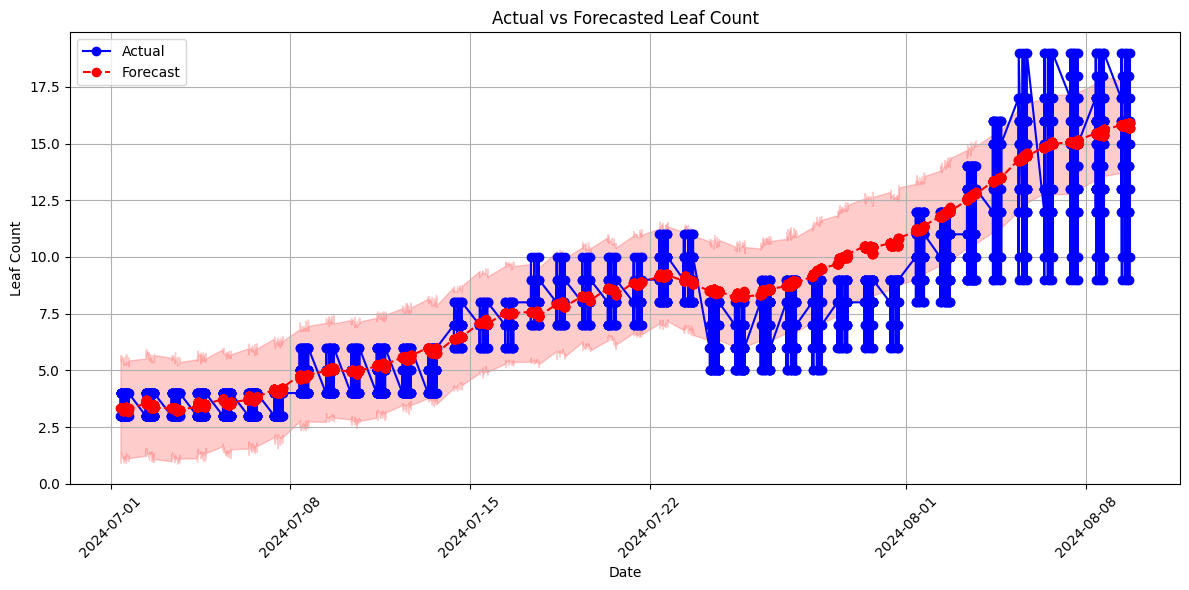

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(visualization_data['ds'], visualization_data['y'], marker='o', linestyle='-', color='blue', label='Actual')

# Plot forecasted values
plt.plot(visualization_data['ds'], visualization_data['yhat'], marker='o', linestyle='--', color='red', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(visualization_data['ds'], visualization_data['yhat_lower'], visualization_data['yhat_upper'], color='red', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Resampling to calculate daily means for the forecasted data and test data
forecast_daily = forecast.set_index('ds').resample('D').mean().reset_index()

# Include 'ds' in the numeric columns or select it separately
numeric_columns = df_test.select_dtypes(include=np.number).columns.tolist()  # Convert to list
numeric_columns.append('ds')  # Add 'ds' to the list

df_test_daily = df_test[numeric_columns].set_index('ds').resample('D').mean().reset_index()

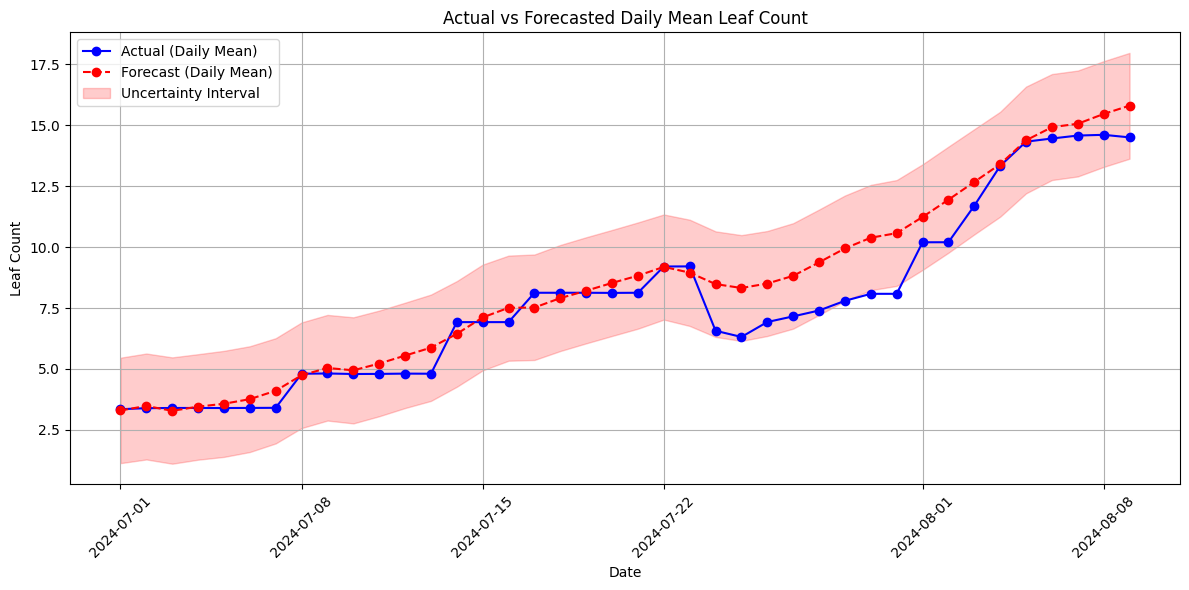

In [ ]:
# Plot Actual vs Forecasted Daily Mean
plt.figure(figsize=(12, 6))
plt.plot(df_test_daily['ds'], df_test_daily['y'], marker='o', linestyle='-', color='blue', label='Actual (Daily Mean)')
plt.plot(forecast_daily['ds'], forecast_daily['yhat'], marker='o', linestyle='--', color='red', label='Forecast (Daily Mean)')
plt.fill_between(forecast_daily['ds'], forecast_daily['yhat_lower'], forecast_daily['yhat_upper'], color='red', alpha=0.2, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Daily Mean Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

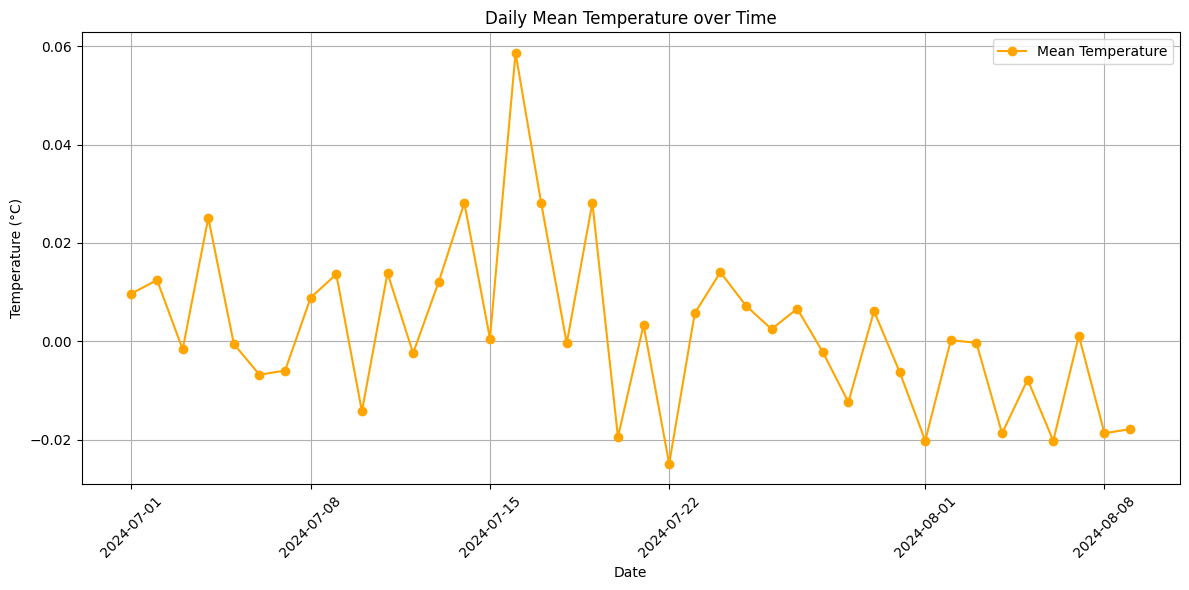

In [ ]:
# Plot Temperature (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(forecast_daily['ds'], forecast_daily['temperature'], marker='o', linestyle='-', color='orange', label='Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Mean Temperature over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

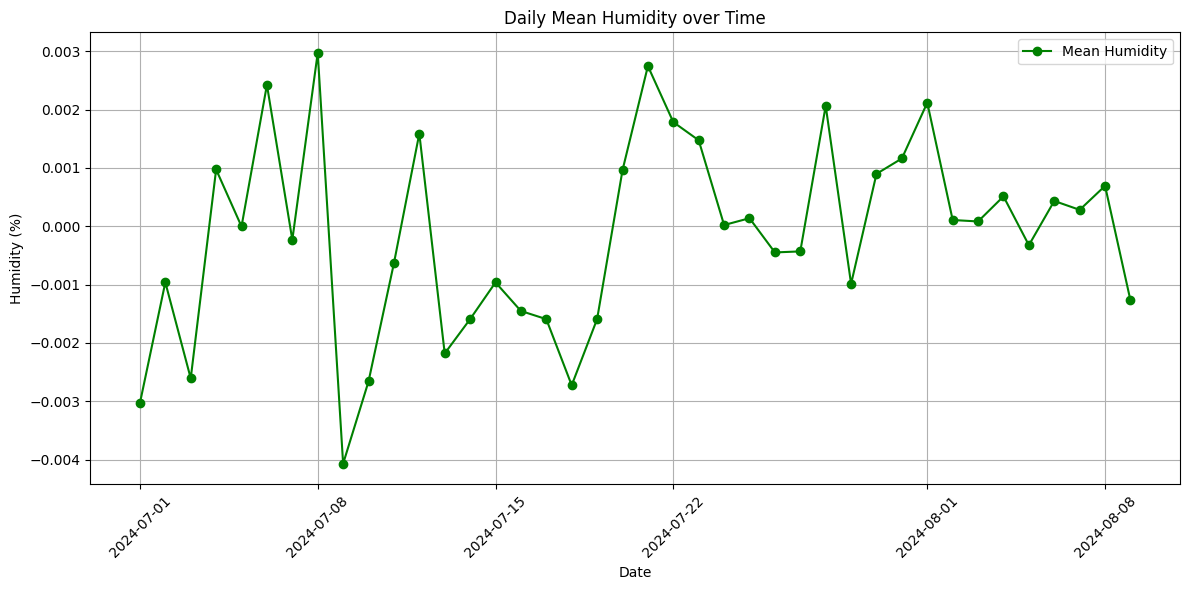

In [ ]:
# Plot Humidity (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(forecast_daily['ds'], forecast_daily['humidity'], marker='o', linestyle='-', color='green', label='Mean Humidity')
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Daily Mean Humidity over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

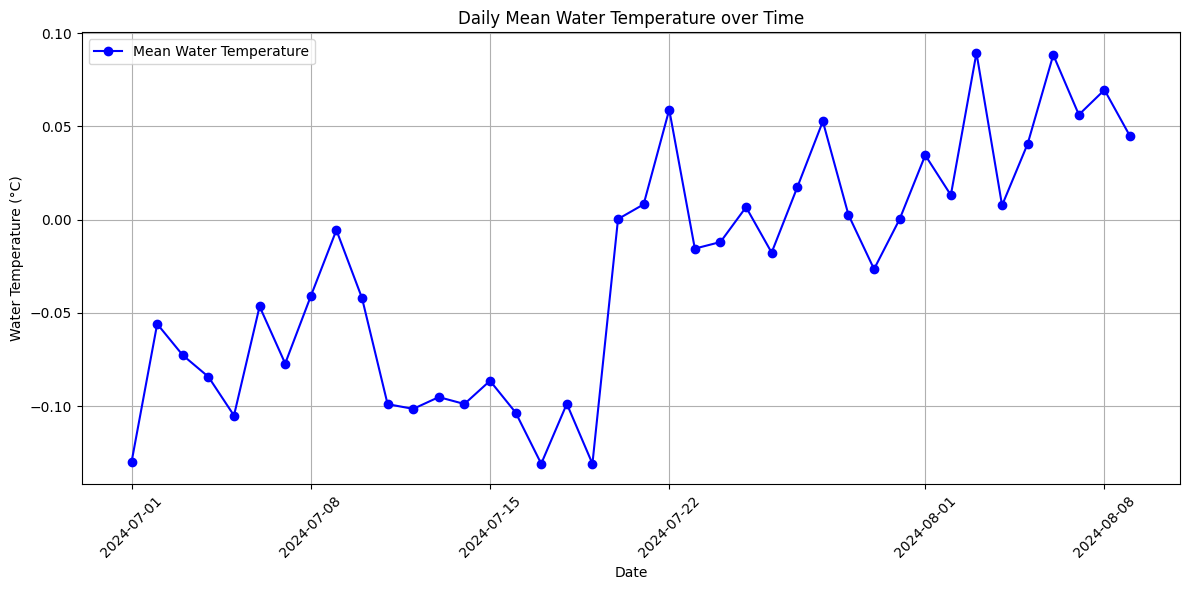

In [ ]:
# Plot Water Temperature (Daily Mean)
plt.figure(figsize=(12, 6))
plt.plot(forecast_daily['ds'], forecast_daily['WaterTemp'], marker='o', linestyle='-', color='blue', label='Mean Water Temperature')
plt.xlabel('Date')
plt.ylabel('Water Temperature (°C)')
plt.title('Daily Mean Water Temperature over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3.3 Final Model

In [ ]:
# Load the datasets
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

# Prepare training data for Prophet
df_train = df_train.reset_index()
df_train = df_train.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})

In [ ]:
# Add a cap for logistic growth
df_train['cap'] = 18  # Maximum value for LeafCount (lettuce growth limit)

# Prepare testing data for evaluation
df_test = df_test.reset_index()
df_test = df_test.rename(columns={'datetime': 'ds'})

# Add the cap to the testing data
df_test['cap'] = 18  # Ensure the cap is consistent with training data

In [ ]:
# Best hyperparameters from fine-tuning
best_params = {
    'changepoint_prior_scale': 0.47049427003815136,
    'seasonality_prior_scale': 0.011990229693586926,
    'holidays_prior_scale': 0.010667405900474347
}

# Add cap for logistic growth
df_train['cap'] = 18  # Maximum value for LeafCount

In [ ]:
# Initialize the best model with fine-tuned hyperparameters
best_model = Prophet(
    growth='logistic',
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    holidays_prior_scale=best_params['holidays_prior_scale']
)
best_model.add_regressor('temperature')
best_model.add_regressor('humidity')
best_model.add_regressor('WaterTemp')

In [ ]:
# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(df_train)):
    train_data = df_train.iloc[train_idx]
    val_data = df_train.iloc[val_idx]

    # Initialize a new Prophet model for each fold
    best_model = Prophet(
        growth='logistic',
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale']
    )
    best_model.add_regressor('temperature')
    best_model.add_regressor('humidity')
    best_model.add_regressor('WaterTemp')

    # Fit the model on training data
    best_model.fit(train_data)

    # Prepare validation data
    val_data_future = val_data[['ds', 'temperature', 'humidity', 'WaterTemp', 'cap']]

    # Make predictions
    forecast = best_model.predict(val_data_future)

    # Calculate RMSE for the fold
    rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
    fold_results.append({'fold': fold + 1, 'rmse': rmse})

    # Focus on Fold 4
    if fold + 1 == 4:
        print(f"Fold {fold + 1} RMSE: {rmse}")
        detailed_forecast = forecast.copy()

# Save K-Fold results to a DataFrame
kfold_results = pd.DataFrame(fold_results)
print("K-Fold Results:")
print(kfold_results)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48q3hgdx/r85dfunb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp48q3hgdx/i6pq6dfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15350', 'data', 'file=/tmp/tmp48q3hgdx/r85dfunb.json', 'init=/tmp/tmp48q3hgdx/i6pq6dfo.json', 'output', 'file=/tmp/tmp48q3hgdx/prophet_modeltgxl_okv/prophet_model-20241217102416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/t

Fold 4 RMSE: 1.6687963205364922


DEBUG:cmdstanpy:input tempfile: /tmp/tmp48q3hgdx/smjj92h3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83372', 'data', 'file=/tmp/tmp48q3hgdx/4exwse9q.json', 'init=/tmp/tmp48q3hgdx/smjj92h3.json', 'output', 'file=/tmp/tmp48q3hgdx/prophet_model1b29gt3x/prophet_model-20241217102430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


K-Fold Results:
   fold      rmse
0     1  1.667158
1     2  1.674932
2     3  1.741896
3     4  1.668796
4     5  1.757558


In [ ]:
# Add cap to the testing data
df_test['cap'] = 18

# Prepare testing data for predictions
df_test_future = df_test[['ds', 'temperature', 'humidity', 'WaterTemp', 'cap']]

# Ensure the test set has the required columns
df_test = df_test.rename(columns={'LeafCount': 'y'})  # Rename the target column to 'y'

# Make predictions on the test set
test_forecast = best_model.predict(df_test_future)

# Calculate Test RMSE and MAE
rmse_test = np.sqrt(mean_squared_error(df_test['y'], test_forecast['yhat']))
mae_test = np.mean(np.abs(df_test['y'] - test_forecast['yhat']))
print(f"Test RMSE: {rmse_test}")
print(f"Test MAE: {mae_test}")

Test RMSE: 1.7659554748887172
Test MAE: 1.3375566117753002


In [ ]:
# Prepare the visualization data
visualization_data = pd.DataFrame({
    'ds': test_forecast['ds'],  # Dates from the test forecast
    'y': df_test['y'].values,  # Actual values from the test set
    'yhat': test_forecast['yhat'],  # Forecasted values
    'yhat_lower': test_forecast['yhat_lower'],  # Lower bound of predictions
    'yhat_upper': test_forecast['yhat_upper'],  # Upper bound of predictions
})

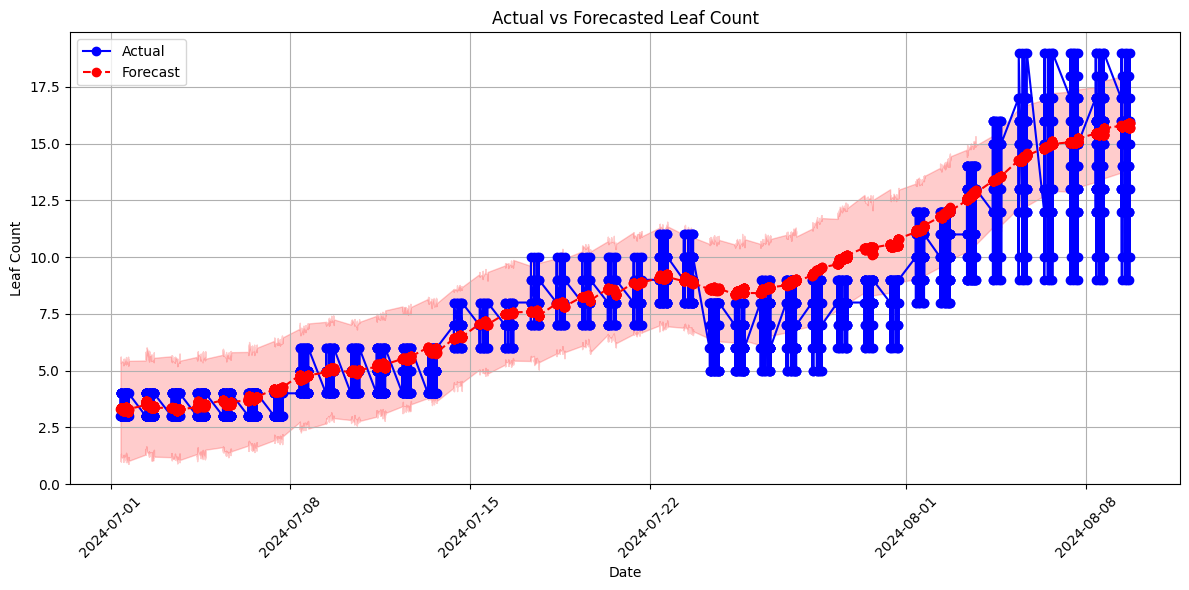

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(visualization_data['ds'], visualization_data['y'], marker='o', linestyle='-', color='blue', label='Actual')

# Plot forecasted values
plt.plot(visualization_data['ds'], visualization_data['yhat'], marker='o', linestyle='--', color='red', label='Forecast')

# Plot the uncertainty intervals
plt.fill_between(visualization_data['ds'], visualization_data['yhat_lower'], visualization_data['yhat_upper'], color='red', alpha=0.2)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Leaf Count')
plt.title('Actual vs Forecasted Leaf Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
df_test = pd.read_csv("/content/dataset_test_final.csv")

# Resample df_test to group by days (ensuring 40 unique days)
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

# Exclude 'time' column from the resampling and mean calculation
df_test_daily = df_test.drop(columns=['time']).resample('D').mean().reset_index()

df_test_daily = df_test_daily.rename(columns={'datetime': 'ds', 'LeafCount': 'y'})
df_test_daily['cap'] = 18  # Add cap for logistic growth

# Ensure there are 40 days in the grouped data
print(f"Total unique days: {df_test_daily['ds'].nunique()}")

Total unique days: 40


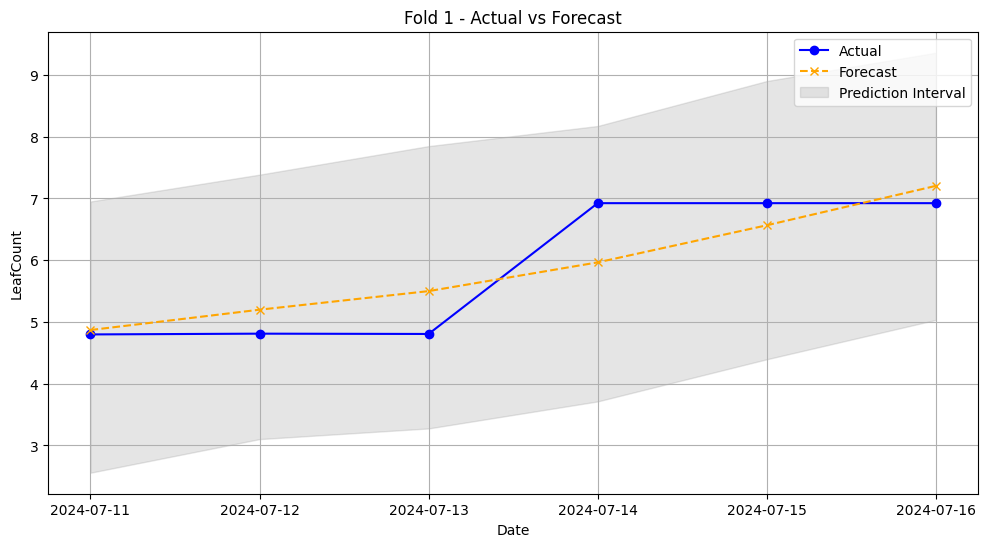

Fold 1 RMSE: 0.5419883144887273


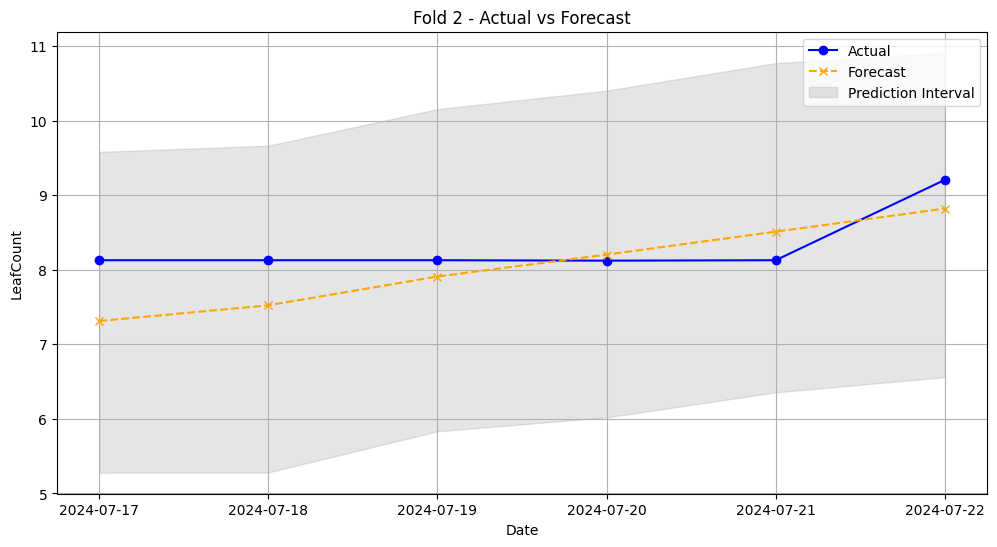

Fold 2 RMSE: 0.4794946410775296


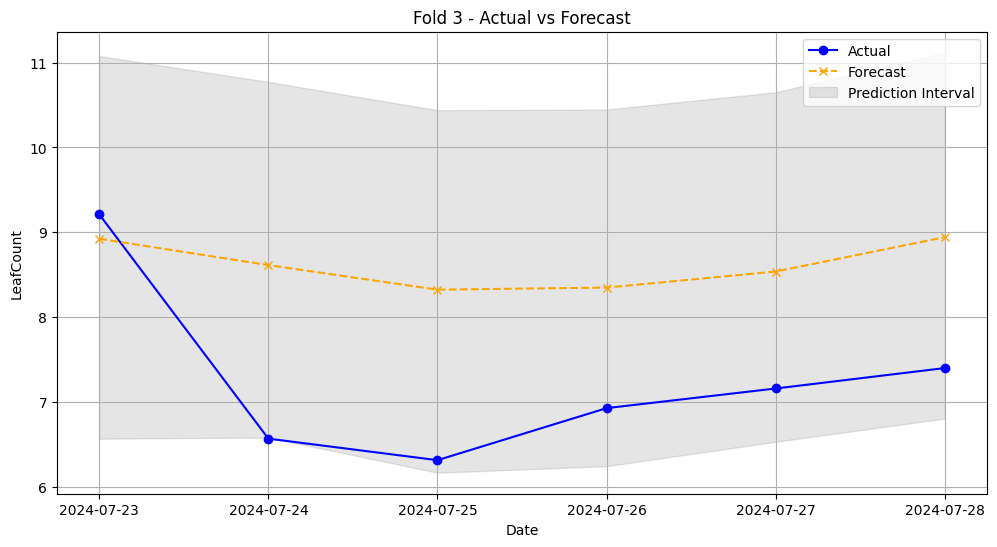

Fold 3 RMSE: 1.5598571800297159


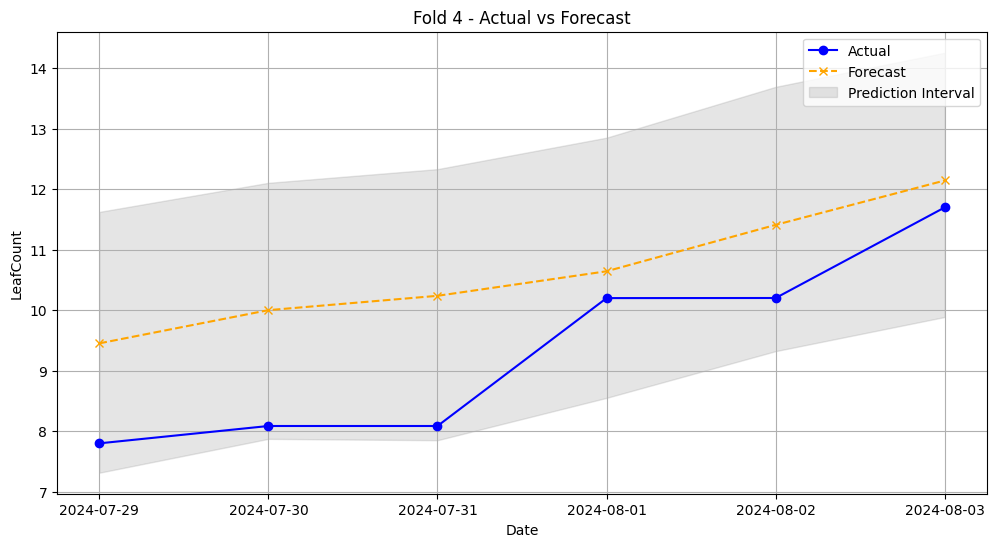

Fold 4 RMSE: 1.4662624957750894


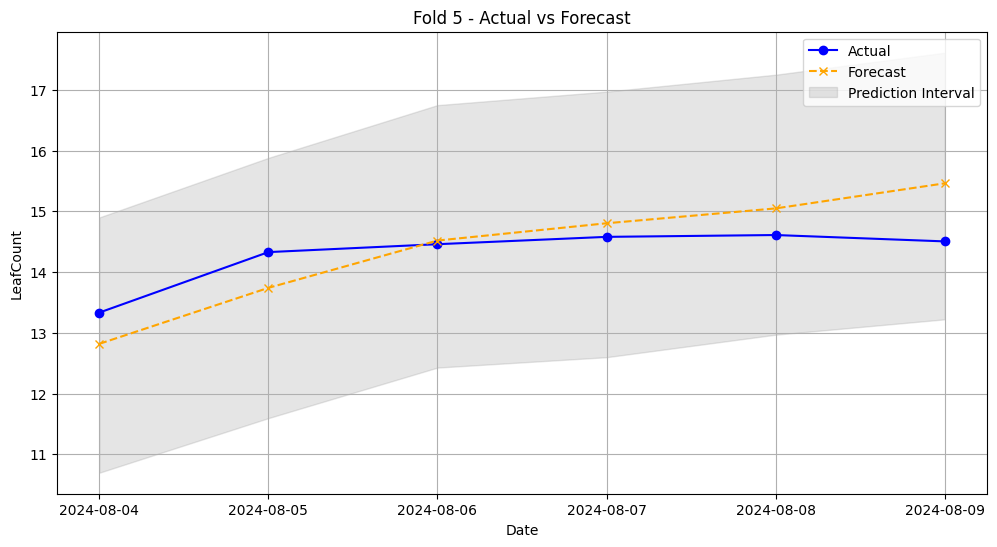

Fold 5 RMSE: 0.5433123841154772
K-Fold Results:
   fold      rmse
0     1  0.541988
1     2  0.479495
2     3  1.559857
3     4  1.466262
4     5  0.543312
Mean RMSE across folds: 0.9181830030973078


In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store fold results
fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_test_daily)):
    # Use best_model for predictions
    train_data = df_test_daily.iloc[train_idx]
    val_data = df_test_daily.iloc[val_idx]

    # Prepare validation data for predictions
    val_data_future = val_data[['ds', 'temperature', 'humidity', 'WaterTemp', 'cap']] # Include regressors
    forecast = best_model.predict(val_data_future)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
    fold_results.append({'fold': fold + 1, 'rmse': rmse})

    # Visualization for the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(val_data['ds'], val_data['y'], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x', linestyle='--', color='orange')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='gray',
        alpha=0.2,
        label='Prediction Interval'
    )
    plt.xlabel('Date')
    plt.ylabel('LeafCount')
    plt.title(f'Fold {fold + 1} - Actual vs Forecast')
    plt.legend()
    plt.grid()
    plt.show()

    # Print RMSE for the fold
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Compile all fold results
kfold_results = pd.DataFrame(fold_results)

# Print overall results
print("K-Fold Results:")
print(kfold_results)

# Calculate and print mean RMSE across all folds
mean_rmse = kfold_results['rmse'].mean()
print(f"Mean RMSE across folds: {mean_rmse}")

In [ ]:
correlation = df_train[['y', 'temperature', 'humidity', 'WaterTemp']].corr()
print("Correlation Matrix:")
print(correlation)

Correlation Matrix:
                    y  temperature  humidity  WaterTemp
y            1.000000    -0.156904  0.077213  -0.496839
temperature -0.156904     1.000000 -0.392270   0.455165
humidity     0.077213    -0.392270  1.000000  -0.400848
WaterTemp   -0.496839     0.455165 -0.400848   1.000000


In [ ]:
import statsmodels.api as sm

# Prepare the data
X = df_train[['temperature', 'humidity', 'WaterTemp']]
y = df_train['y']

# Add a constant (intercept) for the regression model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()

# Summary of regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     639.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        14:14:16   Log-Likelihood:                -14260.
No. Observations:                5283   AIC:                         2.853e+04
Df Residuals:                    5279   BIC:                         2.855e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          31.9508      0.970     32.956      

In [ ]:
# Train a model without regressors
simple_model = Prophet(growth='logistic')
simple_model.fit(df_train[['ds', 'y', 'cap']])

# Predict without regressors
simple_forecast = simple_model.predict(df_test[['ds', 'cap']])

# Calculate metrics
rmse_simple = np.sqrt(mean_squared_error(df_test['y'], simple_forecast['yhat']))
print(f"RMSE without regressors: {rmse_simple}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80kuba_r/dezvlg_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp80kuba_r/ejs2wh8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99995', 'data', 'file=/tmp/tmp80kuba_r/dezvlg_z.json', 'init=/tmp/tmp80kuba_r/ejs2wh8f.json', 'output', 'file=/tmp/tmp80kuba_r/prophet_modelbh5o9qty/prophet_model-20241215141426.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:14:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE without regressors: 1.812345417867998


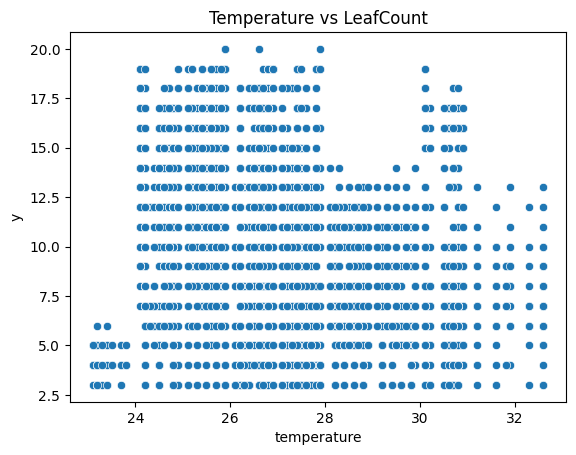

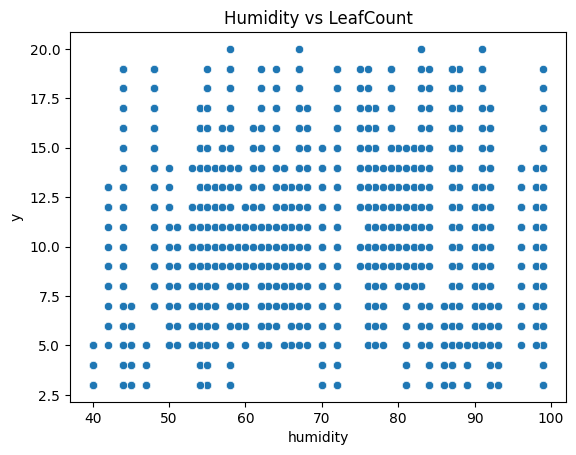

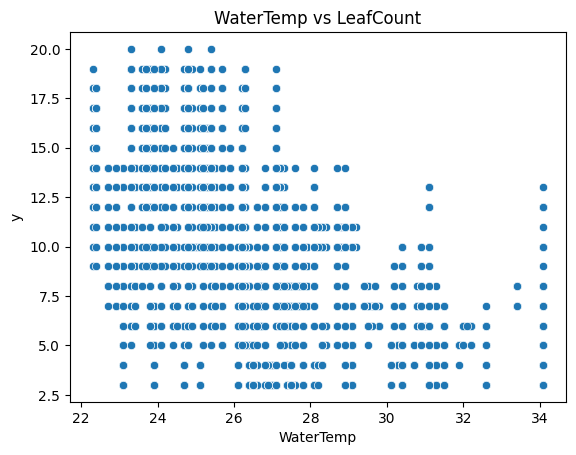

In [ ]:
# Temperature vs LeafCount
sns.scatterplot(data=df_train, x='temperature', y='y')
plt.title('Temperature vs LeafCount')
plt.show()

# Humidity vs LeafCount
sns.scatterplot(data=df_train, x='humidity', y='y')
plt.title('Humidity vs LeafCount')
plt.show()

# WaterTemp vs LeafCount
sns.scatterplot(data=df_train, x='WaterTemp', y='y')
plt.title('WaterTemp vs LeafCount')
plt.show()

In [ ]:
import pickle

# Save the trained model to a file
model_filename = "best_prophet_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to best_prophet_model.pkl


# 4. Summary

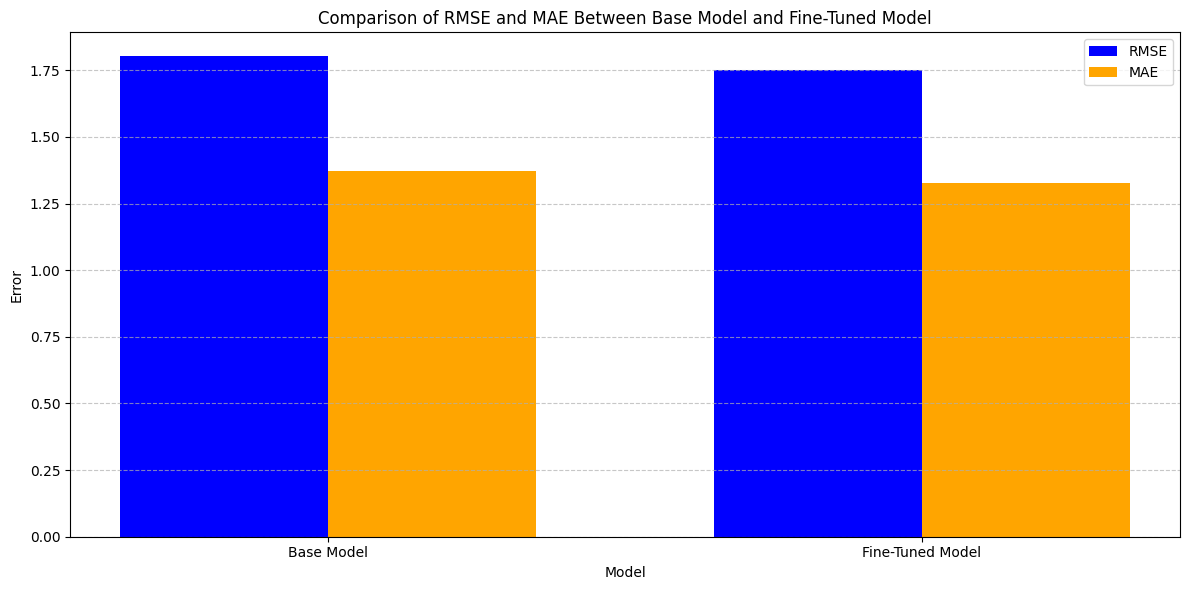

In [ ]:
# Data for comparison
models = ['Base Model', 'Fine-Tuned Model']
rmse_values = [1.8024601856517313, 1.7527506423726291]  # RMSE for both models
mae_values = [1.3722544463287507, 1.326569283293543]  # MAE for both models

# Plot RMSE and MAE comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(models))  # x-axis positions
width = 0.35  # Bar width

# Plotting RMSE
plt.bar(x - width/2, rmse_values, width, label='RMSE', color='blue')

# Plotting MAE
plt.bar(x + width/2, mae_values, width, label='MAE', color='orange')

# Customizing the plot
plt.xlabel('Model')
plt.ylabel('Error')
plt.title('Comparison of RMSE and MAE Between Base Model and Fine-Tuned Model')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## 4.1 Forecasting dengan Targetnya Variable Lingkungan

In [ ]:
df_train = pd.read_csv("/content/dataset_train_final.csv")
df_test = pd.read_csv("/content/dataset_test_final.csv")

In [ ]:
# Convert datetime to datetime format and set as index
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train.set_index('datetime', inplace=True)

df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.set_index('datetime', inplace=True)

In [ ]:
# Directory to save models
model_save_dir = "./saved_models"
os.makedirs(model_save_dir, exist_ok=True)

### 4.1.1 Base Model

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/srp375wi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/99m8zw5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95065', 'data', 'file=/tmp/tmpl4_foho7/srp375wi.json', 'init=/tmp/tmpl4_foho7/99m8zw5u.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelbkmhairf/prophet_model-20241218051927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting WaterTemp ===
Total unique days: 40


05:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


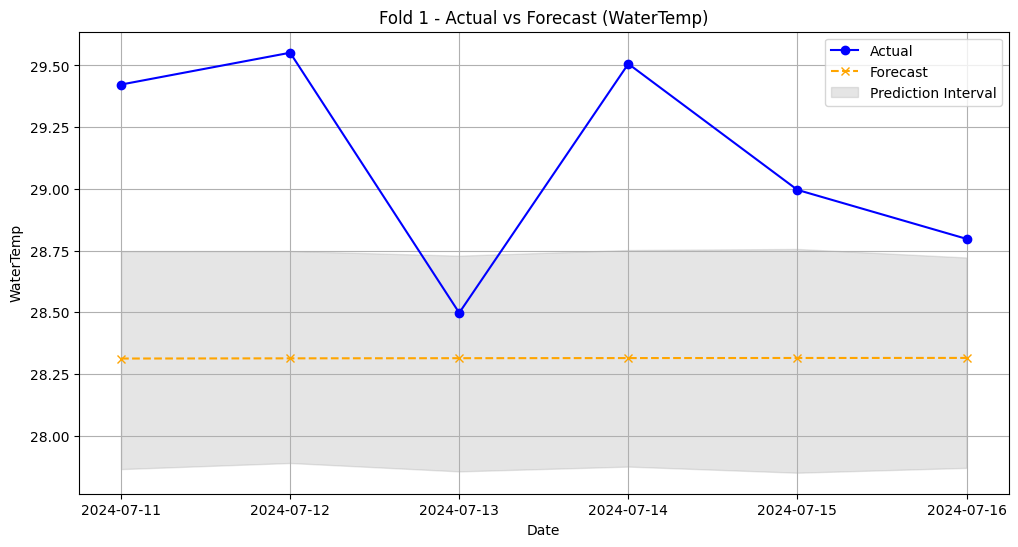

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/gm93aejb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/c5l9thg1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22568', 'data', 'file=/tmp/tmpl4_foho7/gm93aejb.json', 'init=/tmp/tmpl4_foho7/c5l9thg1.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelegccvbli/prophet_model-20241218051927.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1 RMSE: 0.9052988371236182


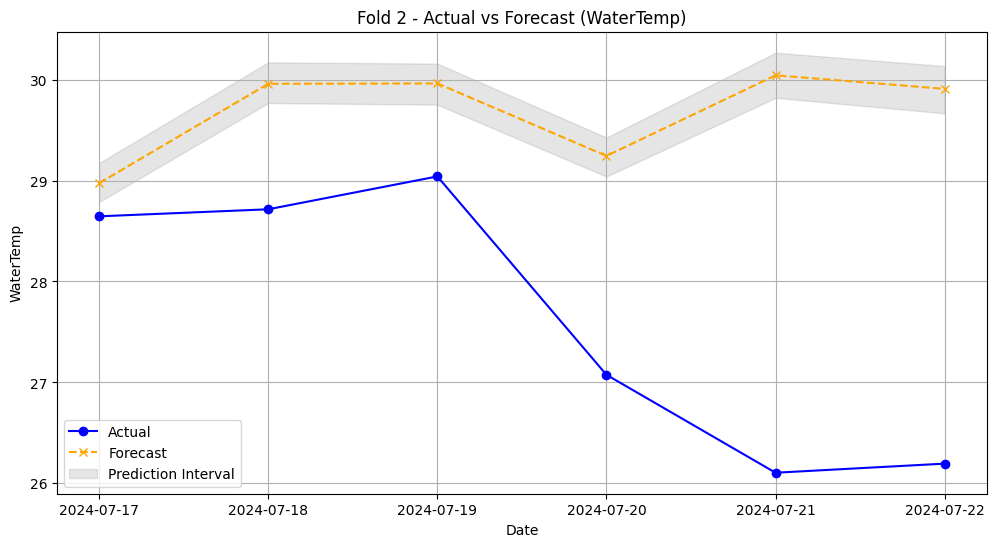

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/qxq2zq47.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/7rmmdqac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67741', 'data', 'file=/tmp/tmpl4_foho7/qxq2zq47.json', 'init=/tmp/tmpl4_foho7/7rmmdqac.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modeldzhrrko4/prophet_model-20241218051928.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 2 RMSE: 2.4658448125128865


05:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


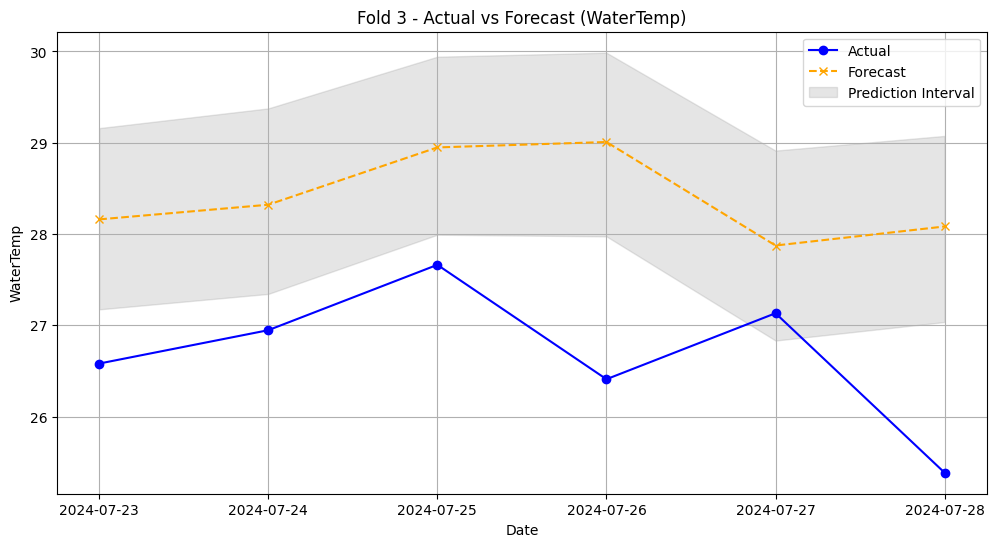

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/9x03v8op.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/co71qlvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23083', 'data', 'file=/tmp/tmpl4_foho7/9x03v8op.json', 'init=/tmp/tmpl4_foho7/co71qlvz.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_model20fhtr43/prophet_model-20241218051929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 3 RMSE: 1.854032998948849


05:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


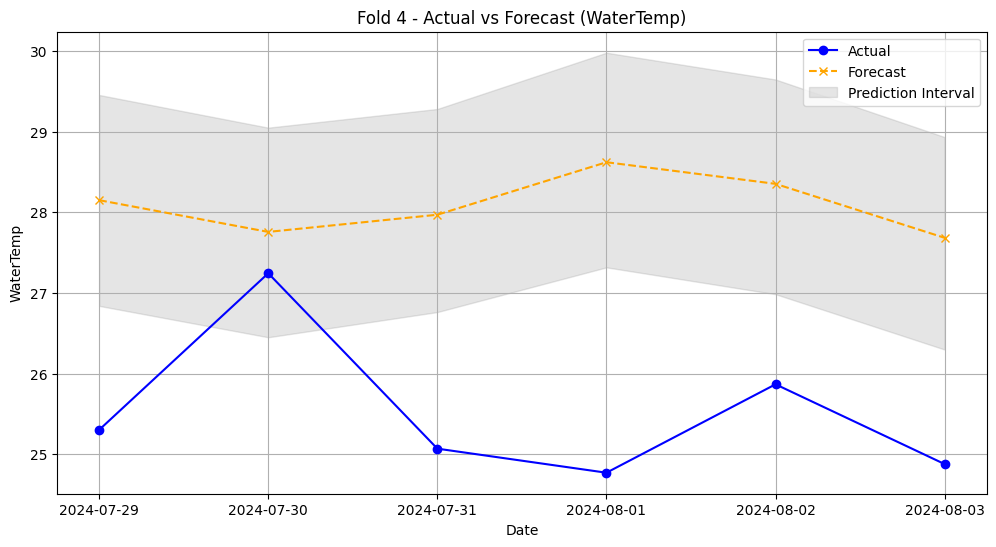

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/wg062ke1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/r_op83p9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27917', 'data', 'file=/tmp/tmpl4_foho7/wg062ke1.json', 'init=/tmp/tmpl4_foho7/r_op83p9.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_model6bxdm9x4/prophet_model-20241218051931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 4 RMSE: 2.756736509306453


05:19:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


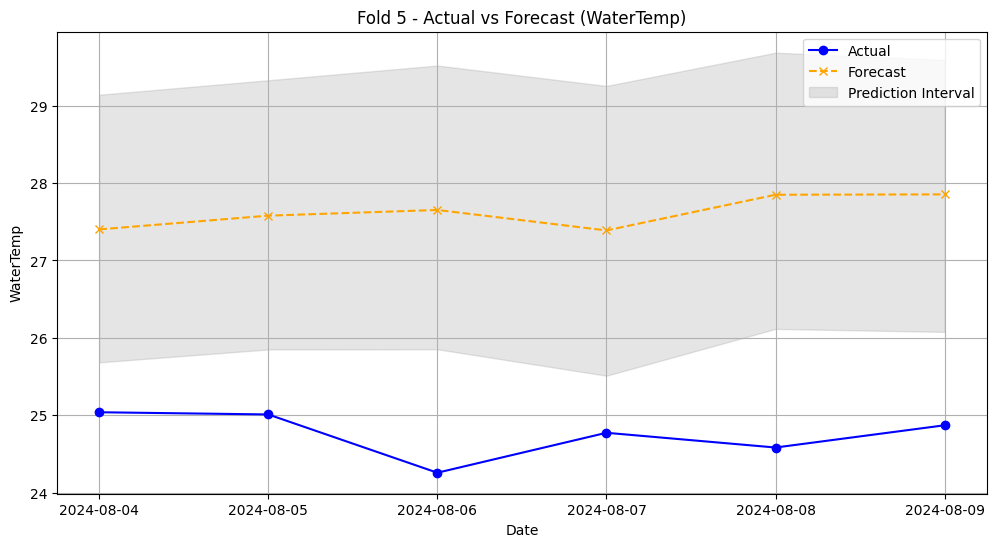

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/h_atshrx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/fvdlxxz3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75201', 'data', 'file=/tmp/tmpl4_foho7/h_atshrx.json', 'init=/tmp/tmpl4_foho7/fvdlxxz3.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelt_685yxj/prophet_model-20241218051932.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO

Fold 5 RMSE: 2.8906888900214547
K-Fold Results for WaterTemp:
   fold      rmse
0     1  0.905299
1     2  2.465845
2     3  1.854033
3     4  2.756737
4     5  2.890689
Mean RMSE for WaterTemp across folds: 2.1745204095826525
Model for WaterTemp saved at: ./saved_models/WaterTemp_prophet_model.pkl

=== Forecasting temperature ===
Total unique days: 40


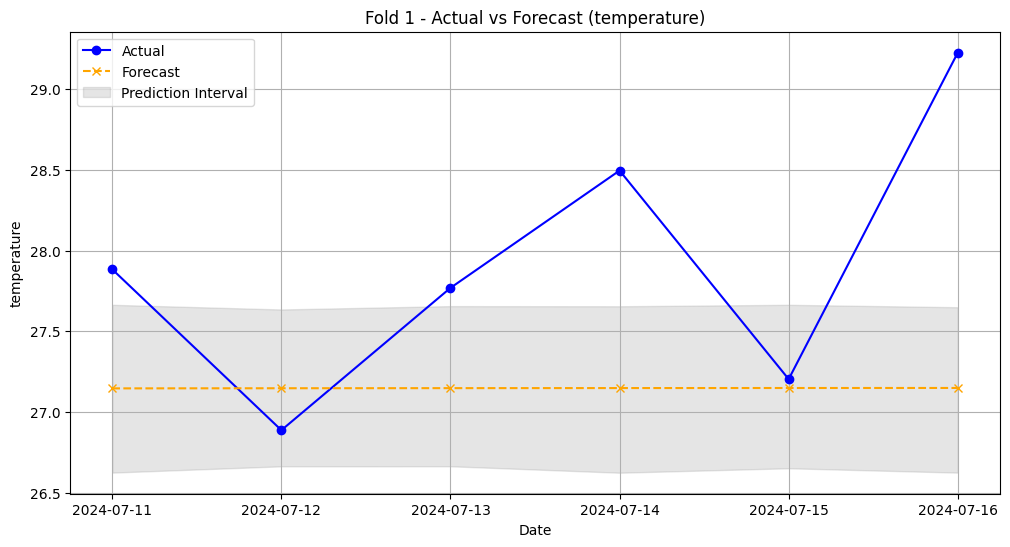

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/cyjvucaf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/l0rcgwcf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34953', 'data', 'file=/tmp/tmpl4_foho7/cyjvucaf.json', 'init=/tmp/tmpl4_foho7/l0rcgwcf.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelfv3r3lnx/prophet_model-20241218051932.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1 RMSE: 1.0895872885801157


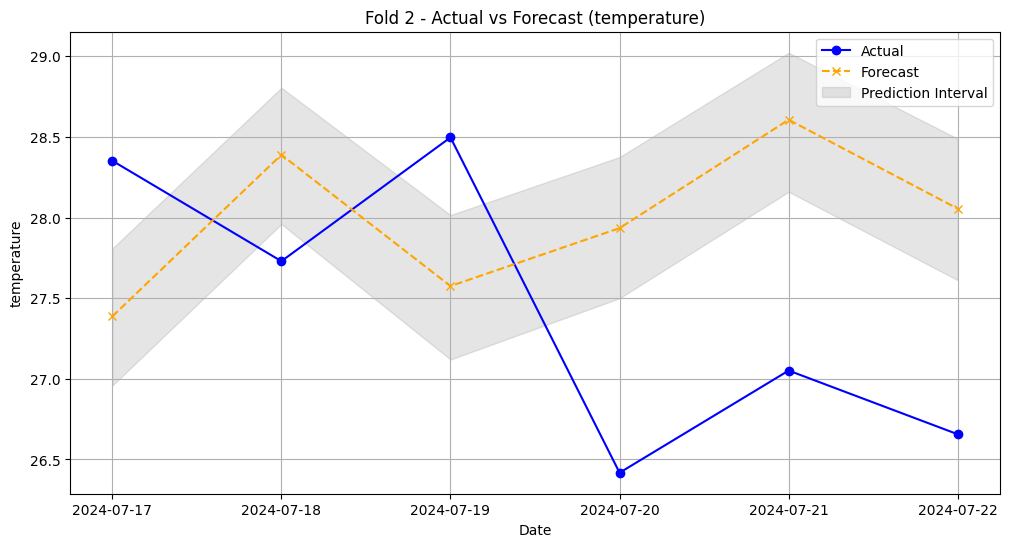

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/6egi0mtu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/49awe7s7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63286', 'data', 'file=/tmp/tmpl4_foho7/6egi0mtu.json', 'init=/tmp/tmpl4_foho7/49awe7s7.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelq526y5rj/prophet_model-20241218051933.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 2 RMSE: 1.217267448028295


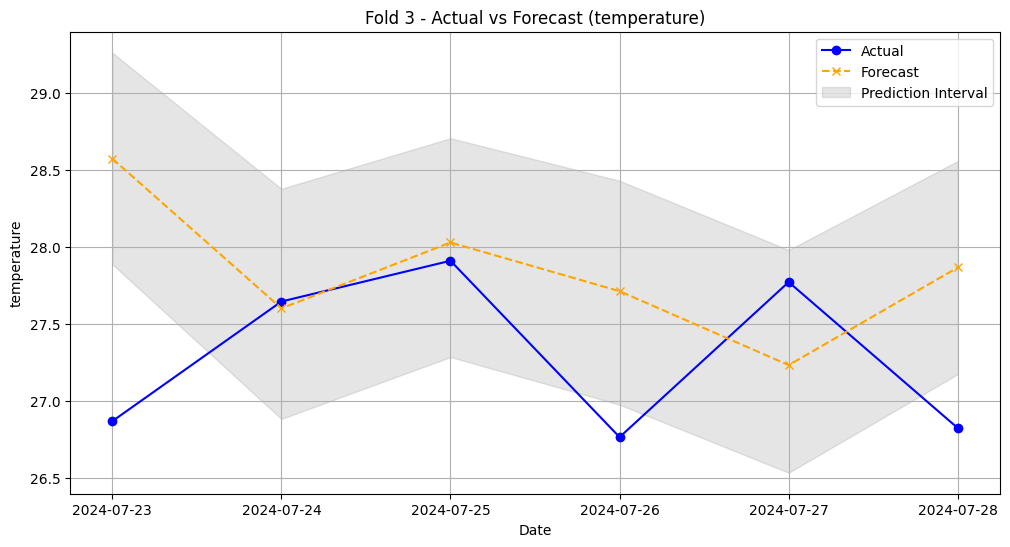

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/jtiic1cb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/aozvt4i_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23989', 'data', 'file=/tmp/tmpl4_foho7/jtiic1cb.json', 'init=/tmp/tmpl4_foho7/aozvt4i_.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_model8kiyq16l/prophet_model-20241218051933.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 3 RMSE: 0.9304514664373352


05:19:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


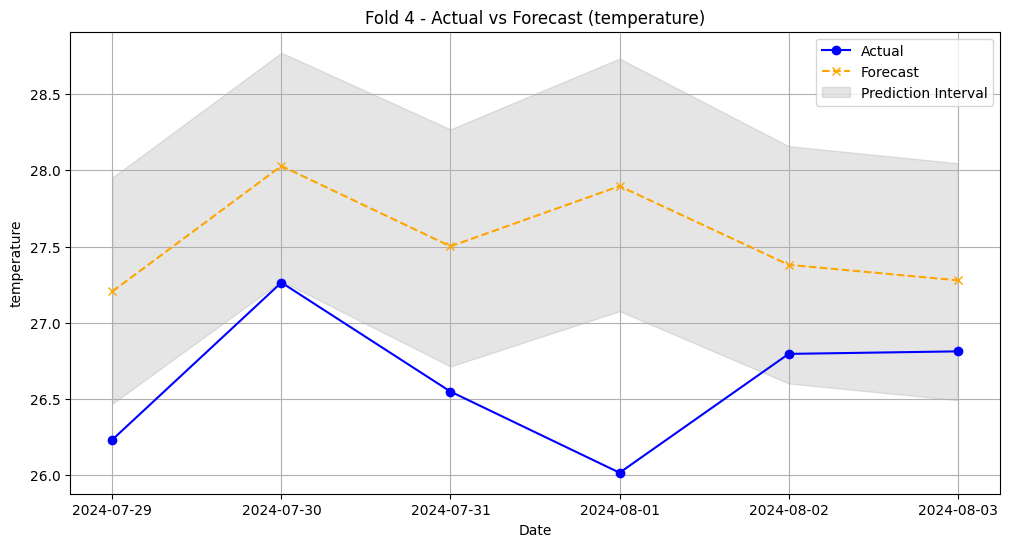

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Fold 4 RMSE: 1.0434119463901126


DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/vsawzu20.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/gerzjm9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63013', 'data', 'file=/tmp/tmpl4_foho7/vsawzu20.json', 'init=/tmp/tmpl4_foho7/gerzjm9w.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelnax3akhr/prophet_model-20241218051934.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


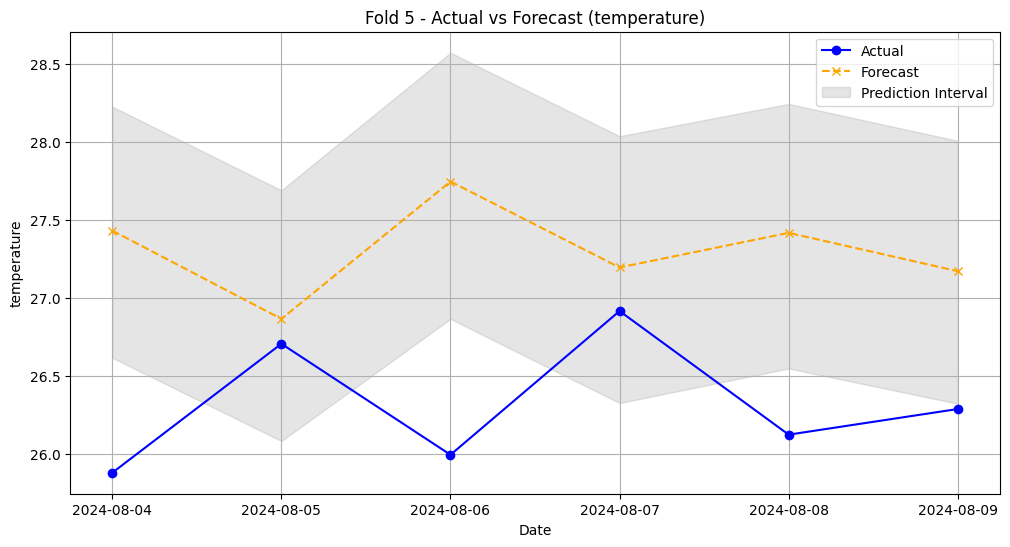

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/x5siunz6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/t9ozjosq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73191', 'data', 'file=/tmp/tmpl4_foho7/x5siunz6.json', 'init=/tmp/tmpl4_foho7/t9ozjosq.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_model2b9niy5k/prophet_model-20241218051936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
INFO

Fold 5 RMSE: 1.1573379582478296
K-Fold Results for temperature:
   fold      rmse
0     1  1.089587
1     2  1.217267
2     3  0.930451
3     4  1.043412
4     5  1.157338
Mean RMSE for temperature across folds: 1.0876112215367377
Model for temperature saved at: ./saved_models/temperature_prophet_model.pkl

=== Forecasting humidity ===
Total unique days: 40


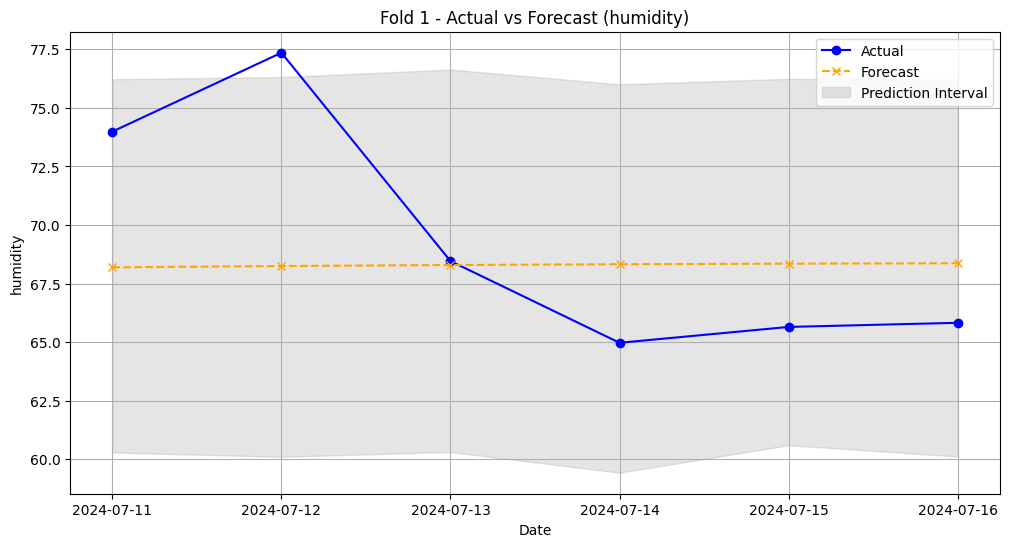

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/z76koube.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/_vvigwge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39710', 'data', 'file=/tmp/tmpl4_foho7/z76koube.json', 'init=/tmp/tmpl4_foho7/_vvigwge.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_model5iqgau1f/prophet_model-20241218051936.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 1 RMSE: 4.854804139263217


05:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


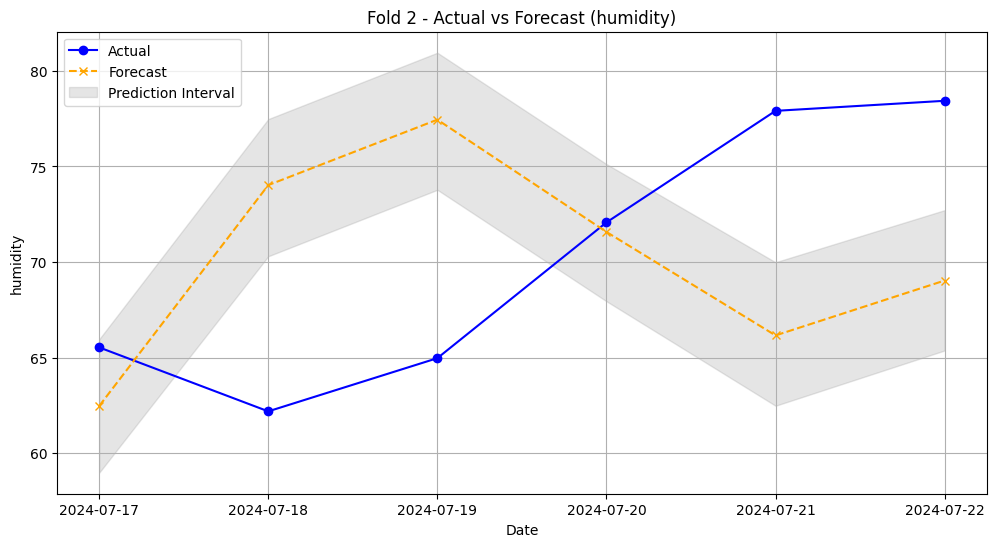

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/4ea3vvzz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/ghkz5m0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84701', 'data', 'file=/tmp/tmpl4_foho7/4ea3vvzz.json', 'init=/tmp/tmpl4_foho7/ghkz5m0m.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelqlnhvmql/prophet_model-20241218051937.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 2 RMSE: 9.410359082631693


05:19:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


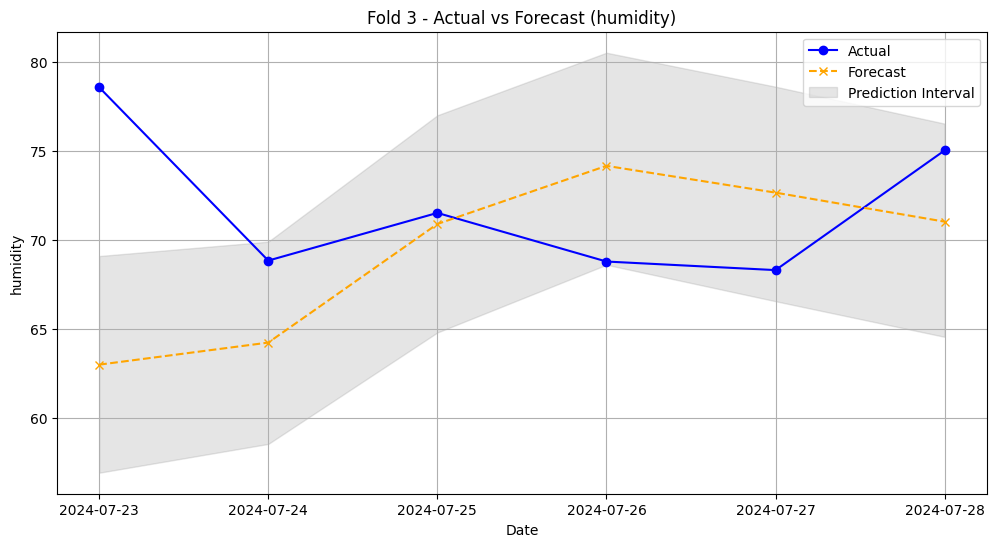

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/xxcb8dc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/0lkj_ovl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69856', 'data', 'file=/tmp/tmpl4_foho7/xxcb8dc1.json', 'init=/tmp/tmpl4_foho7/0lkj_ovl.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modele2q1u2r0/prophet_model-20241218051938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 3 RMSE: 7.386357566792695


05:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


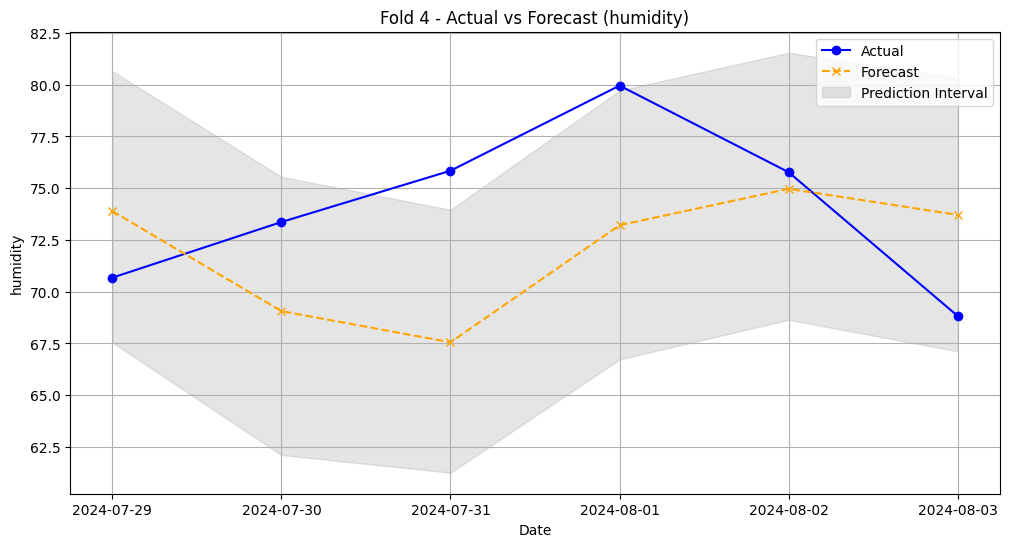

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/xosaup7s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl4_foho7/3zw05sbj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11489', 'data', 'file=/tmp/tmpl4_foho7/xosaup7s.json', 'init=/tmp/tmpl4_foho7/3zw05sbj.json', 'output', 'file=/tmp/tmpl4_foho7/prophet_modelqzolkgff/prophet_model-20241218051938.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 4 RMSE: 5.284180843848658


05:19:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


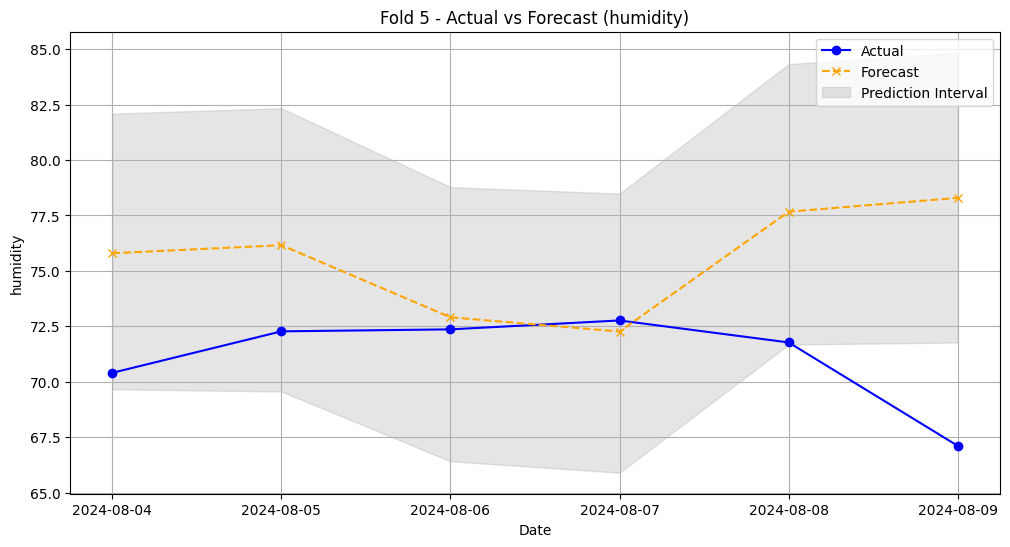

Fold 5 RMSE: 5.8407359855899585
K-Fold Results for humidity:
   fold      rmse
0     1  4.854804
1     2  9.410359
2     3  7.386358
3     4  5.284181
4     5  5.840736
Mean RMSE for humidity across folds: 6.555287523625244
Model for humidity saved at: ./saved_models/humidity_prophet_model.pkl


In [ ]:
# Concatenate the train and test datasets
df_combined = pd.concat([df_train, df_test])

# Ensure only numeric columns are aggregated during resampling
numeric_columns = df_combined.select_dtypes(include=['number']).columns
df_combined_numeric = df_combined[numeric_columns]

# Resample the combined dataset to ensure daily aggregation
df_combined_daily = df_combined_numeric.resample('D').mean().reset_index()
df_combined_daily = df_combined_daily.rename(columns={'datetime': 'ds'})
df_combined_daily['cap'] = 18  # Add cap for logistic growth

# Define target variables to forecast
target_variables = ['WaterTemp', 'temperature', 'humidity']

# Loop through each target variable
for target in target_variables:
    print(f"\n=== Forecasting {target} ===")

    # Reset column names for each iteration to prepare for Prophet
    df_combined_daily['y'] = df_combined_daily[target]  # Set the current target as 'y'

    # Ensure the combined dataset includes all unique days
    print(f"Total unique days: {df_combined_daily['ds'].nunique()}")

    # Perform K-Fold forecasting
    n_splits = 5
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Store fold results
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(df_combined_daily)):
        # Split into training and validation sets
        train_data = df_combined_daily.iloc[train_idx][['ds', 'y', 'cap']]  # Include only necessary columns
        val_data = df_combined_daily.iloc[val_idx][['ds', 'y', 'cap']]

        # Initialize a simple Prophet model
        model = Prophet(
            growth='logistic',
            changepoint_prior_scale=0.1,  # Simple default hyperparameters
            seasonality_prior_scale=10.0,
            daily_seasonality=True  # Simple daily seasonality
        )

        # Fit the model
        model.fit(train_data)

        # Prepare validation data for predictions
        val_data_future = val_data[['ds', 'cap']]
        forecast = model.predict(val_data_future)

        # Calculate RMSE for this fold
        rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
        fold_results.append({'fold': fold + 1, 'rmse': rmse})

        # Visualization for the current fold
        plt.figure(figsize=(12, 6))
        plt.plot(val_data['ds'], val_data['y'], label='Actual', marker='o', linestyle='-', color='blue')
        plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x', linestyle='--', color='orange')
        plt.fill_between(
            forecast['ds'],
            forecast['yhat_lower'],
            forecast['yhat_upper'],
            color='gray',
            alpha=0.2,
            label='Prediction Interval'
        )
        plt.xlabel('Date')
        plt.ylabel(target)
        plt.title(f'Fold {fold + 1} - Actual vs Forecast ({target})')
        plt.legend()
        plt.grid()
        plt.show()

        # Print RMSE for the fold
        print(f"Fold {fold + 1} RMSE: {rmse}")

    # Compile all fold results
    kfold_results = pd.DataFrame(fold_results)

    # Print overall results
    print(f"K-Fold Results for {target}:")
    print(kfold_results)

    # Calculate and print mean RMSE across all folds
    mean_rmse = kfold_results['rmse'].mean()
    print(f"Mean RMSE for {target} across folds: {mean_rmse}")

    # Save the model for the current target
    model_save_path = os.path.join(model_save_dir, f"{target}_prophet_model.pkl")
    joblib.dump(model, model_save_path)
    print(f"Model for {target} saved at: {model_save_path}")

### 4.1.2 Hyperparameter

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/e8kdwz1p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/t39qfe_1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69567', 'data', 'file=/tmp/tmprd57ypgk/e8kdwz1p.json', 'init=/tmp/tmprd57ypgk/t39qfe_1.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modeljrrprr85/prophet_model-20241217142138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:38 - cmdstanpy - INFO - Chain [1] done processing
INFO

Total unique days: 40


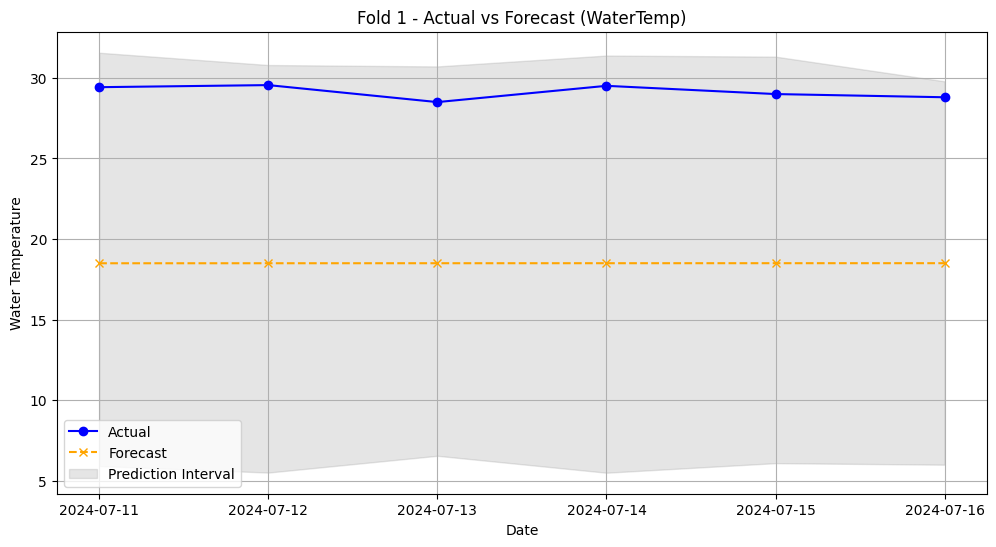

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/xrcanlqc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/xqnbga_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34403', 'data', 'file=/tmp/tmprd57ypgk/xrcanlqc.json', 'init=/tmp/tmprd57ypgk/xqnbga_n.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelwokhqt3k/prophet_model-20241217142139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Fold 1 RMSE: 10.633815423285013


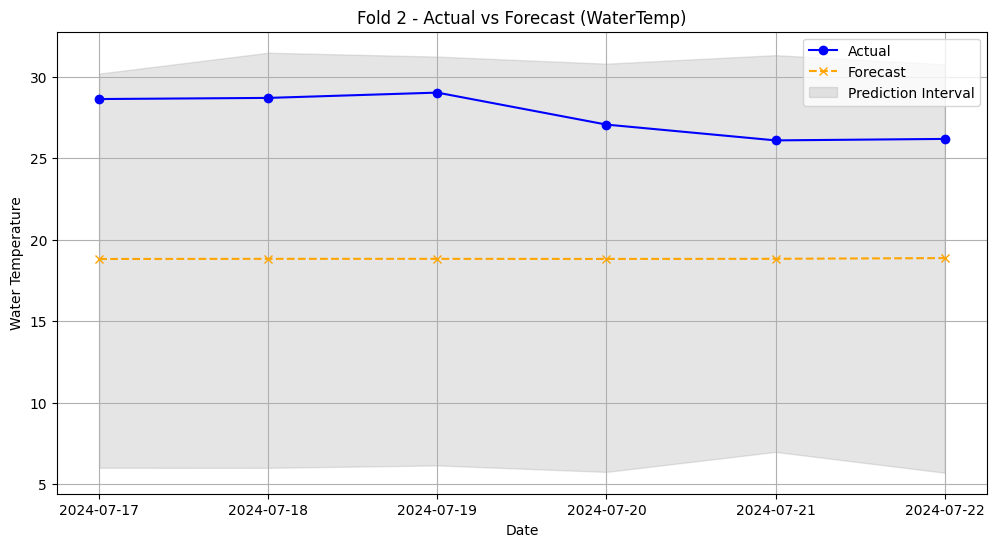

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/ufn4qep6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/yjxyajm7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26176', 'data', 'file=/tmp/tmprd57ypgk/ufn4qep6.json', 'init=/tmp/tmprd57ypgk/yjxyajm7.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelxwm_w6pd/prophet_model-20241217142139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 2 RMSE: 8.880362097837882


14:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


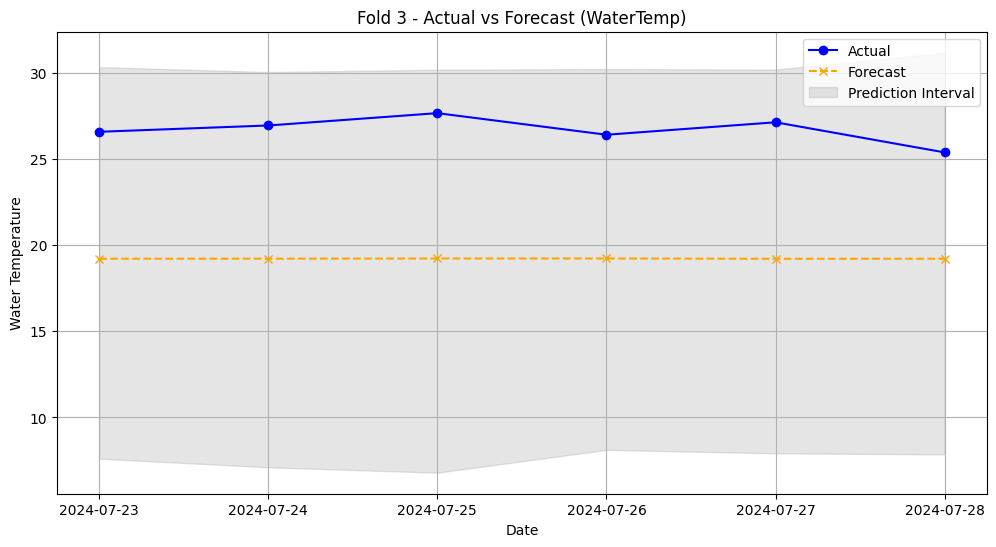

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/b0mnk9_2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/8tjwif5w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85570', 'data', 'file=/tmp/tmprd57ypgk/b0mnk9_2.json', 'init=/tmp/tmprd57ypgk/8tjwif5w.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelhwydumqo/prophet_model-20241217142140.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 3 RMSE: 7.500677355291036


14:21:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


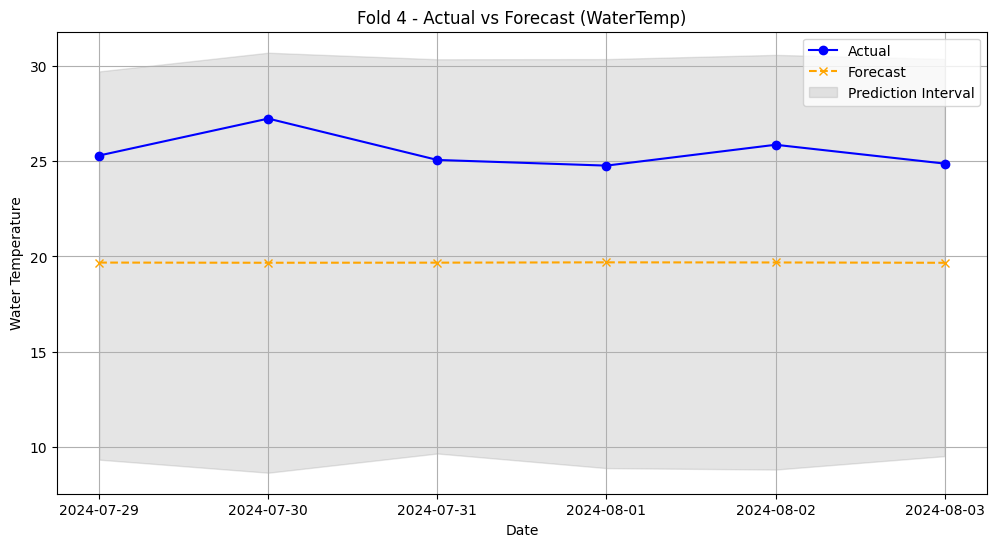

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/rqdsedl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/hdl_7cln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96335', 'data', 'file=/tmp/tmprd57ypgk/rqdsedl3.json', 'init=/tmp/tmprd57ypgk/hdl_7cln.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelvr1pztrr/prophet_model-20241217142141.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Fold 4 RMSE: 5.9084698214330444


14:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


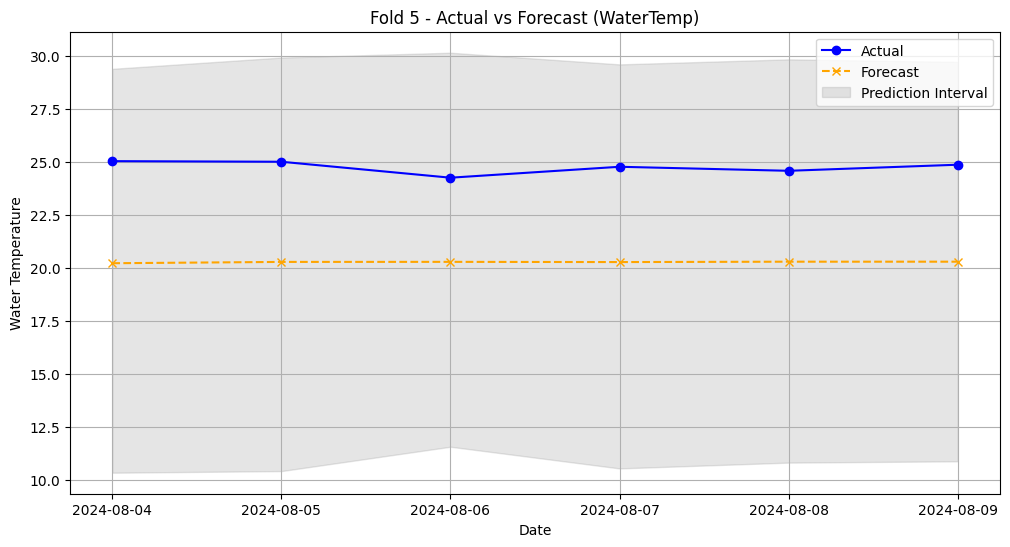

Fold 5 RMSE: 4.492132359394908
K-Fold Results:
   fold       rmse
0     1  10.633815
1     2   8.880362
2     3   7.500677
3     4   5.908470
4     5   4.492132
Mean RMSE across folds: 7.4830914114483775


In [ ]:
# Concatenate the train and test datasets
df_combined = pd.concat([df_train, df_test])

# Ensure only numeric columns are aggregated during resampling
numeric_columns = df_combined.select_dtypes(include=['number']).columns
df_combined_numeric = df_combined[numeric_columns]

# Resample the combined dataset to ensure daily aggregation
df_combined_daily = df_combined_numeric.resample('D').mean().reset_index()
df_combined_daily = df_combined_daily.rename(columns={'datetime': 'ds'})
df_combined_daily['cap'] = 18  # Add cap for logistic growth

# Set 'WaterTemp' as the target variable (y)
df_combined_daily = df_combined_daily.rename(columns={'WaterTemp': 'y'})

# Ensure the combined dataset includes all unique days
print(f"Total unique days: {df_combined_daily['ds'].nunique()}")

# Best hyperparameters from fine-tuning
best_params = {
    'changepoint_prior_scale': 0.47049427003815136,
    'seasonality_prior_scale': 0.011990229693586926,
    'holidays_prior_scale': 0.010667405900474347
}

# Perform K-Fold forecasting
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Store fold results
fold_results = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(df_combined_daily)):
    # Split into training and validation sets
    train_data = df_combined_daily.iloc[train_idx]
    val_data = df_combined_daily.iloc[val_idx]

    # Initialize a Prophet model with the best hyperparameters
    model = Prophet(
        growth='logistic',
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        holidays_prior_scale=best_params['holidays_prior_scale'],
        daily_seasonality=True  # Simple daily seasonality
    )

    # Fit the model
    model.fit(train_data)

    # Prepare validation data for predictions
    val_data_future = val_data[['ds', 'cap']]
    forecast = model.predict(val_data_future)

    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(val_data['y'], forecast['yhat']))
    fold_results.append({'fold': fold + 1, 'rmse': rmse})

    # Visualization for the current fold
    plt.figure(figsize=(12, 6))
    plt.plot(val_data['ds'], val_data['y'], label='Actual', marker='o', linestyle='-', color='blue')
    plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', marker='x', linestyle='--', color='orange')
    plt.fill_between(
        forecast['ds'],
        forecast['yhat_lower'],
        forecast['yhat_upper'],
        color='gray',
        alpha=0.2,
        label='Prediction Interval'
    )
    plt.xlabel('Date')
    plt.ylabel('Water Temperature')
    plt.title(f'Fold {fold + 1} - Actual vs Forecast (WaterTemp)')
    plt.legend()
    plt.grid()
    plt.show()

    # Print RMSE for the fold
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Compile all fold results
kfold_results = pd.DataFrame(fold_results)

# Print overall results
print("K-Fold Results:")
print(kfold_results)

# Calculate and print mean RMSE across all folds
mean_rmse = kfold_results['rmse'].mean()
print(f"Mean RMSE across folds: {mean_rmse}")

### Single Frame

In [ ]:
def forecast_with_test_data(df_train, df_test, target_variables):
    for target in target_variables:
        print(f"\n=== Forecasting {target} Using Test Data with Resampling ===")

        # Resample training data (daily mean), excluding the 'time' column
        df_train_resampled = df_train.drop(columns=['time']).resample('D').mean().reset_index()
        df_train_copy = df_train_resampled.rename(columns={'datetime': 'ds', target: 'y'}).copy()

        # Resample test data (daily mean), excluding the 'time' column
        df_test_resampled = df_test.drop(columns=['time']).resample('D').mean().reset_index()
        df_test_copy = df_test_resampled.rename(columns={'datetime': 'ds'}).copy()

        # Initialize a simple Prophet model
        model = Prophet(
            changepoint_prior_scale=0.1,  # Simple default hyperparameters
            seasonality_prior_scale=10.0,
            daily_seasonality=True  # Simple daily seasonality
        )

        # Fit the model on the training dataset
        model.fit(df_train_copy[['ds', 'y']])

        # Predict on the test dataset
        future = df_test_copy[['ds']]
        forecast = model.predict(future)

        # Combine predictions with test data
        df_test_copy['yhat'] = forecast['yhat']
        df_test_copy['yhat_lower'] = forecast['yhat_lower']
        df_test_copy['yhat_upper'] = forecast['yhat_upper']

        # Visualization of test data and forecast
        plt.figure(figsize=(12, 6))
        plt.plot(df_train_copy['ds'], df_train_copy['y'], label='Training Data', marker='o', linestyle='-', color='blue')
        plt.plot(df_test_copy['ds'], df_test_copy[target], label='Test Data (Actual)', marker='o', linestyle='-', color='green')
        plt.plot(df_test_copy['ds'], df_test_copy['yhat'], label='Forecast', marker='x', linestyle='--', color='orange')
        plt.fill_between(
            df_test_copy['ds'],
            df_test_copy['yhat_lower'],
            df_test_copy['yhat_upper'],
            color='gray',
            alpha=0.2,
            label='Prediction Interval'
        )
        plt.xlabel('Date')
        plt.ylabel(target)
        plt.title(f'Forecast for {target} Using Test Data with Resampling')
        plt.legend()
        plt.grid()
        plt.show()

        # Print forecasted values for the test dataset
        print(f"\nForecast for {target} (Test Data):")
        print(df_test_copy[['ds', target, 'yhat', 'yhat_lower', 'yhat_upper']])


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/z2v0zj1_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/ptlab_jz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21064', 'data', 'file=/tmp/tmprd57ypgk/z2v0zj1_.json', 'init=/tmp/tmprd57ypgk/ptlab_jz.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelobqscisb/prophet_model-20241217144107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:41:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



=== Forecasting WaterTemp Using Test Data with Resampling ===


14:41:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


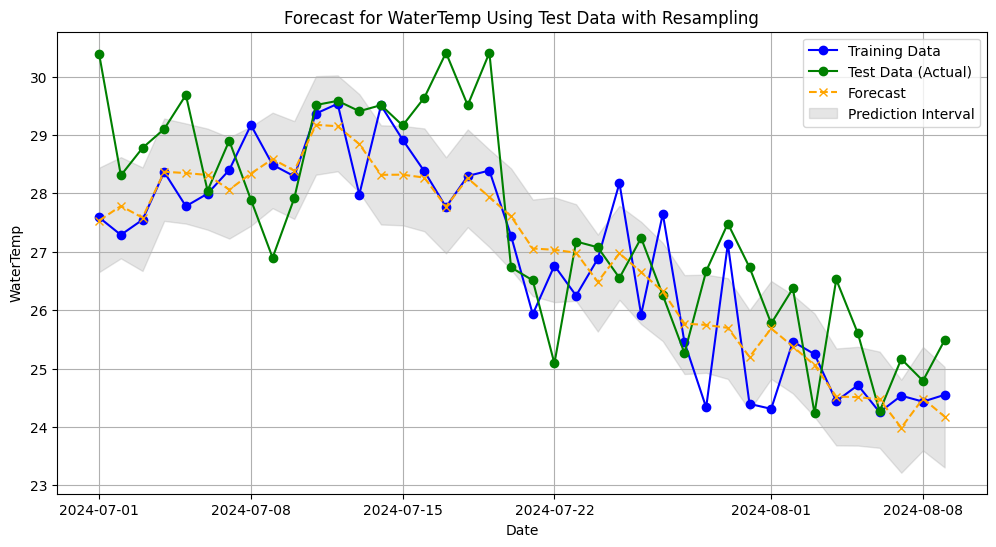

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/itr2xbjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/rtcjiu4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94358', 'data', 'file=/tmp/tmprd57ypgk/itr2xbjo.json', 'init=/tmp/tmprd57ypgk/rtcjiu4w.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelkh_5c5p4/prophet_model-20241217144109.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:41:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Forecast for WaterTemp (Test Data):
           ds  WaterTemp       yhat  yhat_lower  yhat_upper
0  2024-07-01  30.380000  27.534052   26.651748   28.439759
1  2024-07-02  28.306897  27.782687   26.886430   28.619543
2  2024-07-03  28.777333  27.583262   26.670632   28.443696
3  2024-07-04  29.101250  28.369466   27.527785   29.280518
4  2024-07-05  29.683562  28.346881   27.481366   29.196563
5  2024-07-06  28.043925  28.314170   27.377092   29.108123
6  2024-07-07  28.901887  28.062624   27.224897   28.957324
7  2024-07-08  27.889610  28.338991   27.444203   29.143009
8  2024-07-09  26.896923  28.587144   27.744698   29.381222
9  2024-07-10  27.917647  28.387235   27.561601   29.236937
10 2024-07-11  29.512360  29.172715   28.318474   30.006377
11 2024-07-12  29.583544  29.148942   28.377383   30.019800
12 2024-07-13  29.406494  28.842581   28.013528   29.698060
13 2024-07-14  29.510256  28.316942   27.466370   29.164309
14 2024-07-15  29.161538  28.319275   27.452063   29.154263
15 

14:41:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


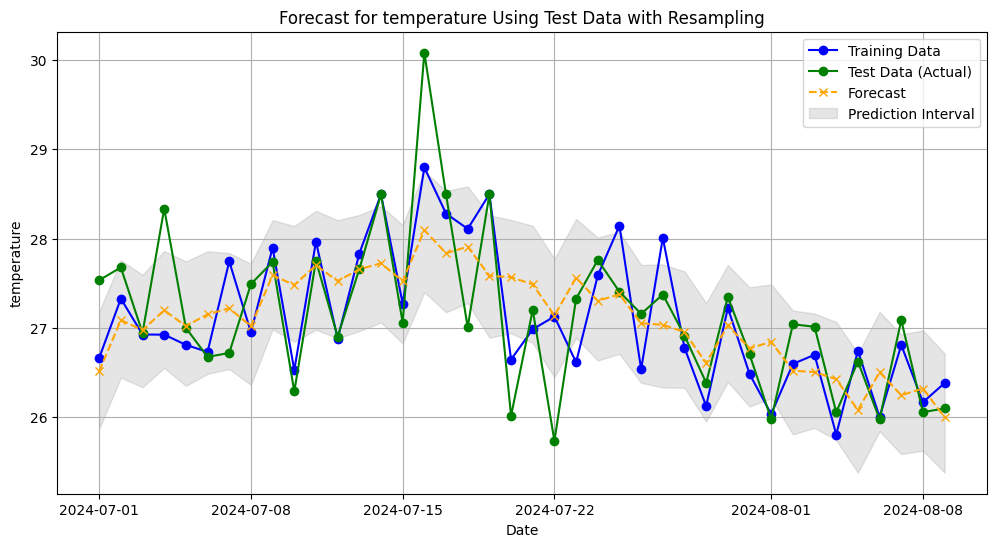

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/efe7wxt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprd57ypgk/uousa3up.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57230', 'data', 'file=/tmp/tmprd57ypgk/efe7wxt4.json', 'init=/tmp/tmprd57ypgk/uousa3up.json', 'output', 'file=/tmp/tmprd57ypgk/prophet_modelwh_nval0/prophet_model-20241217144110.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:41:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing



Forecast for temperature (Test Data):
           ds  temperature       yhat  yhat_lower  yhat_upper
0  2024-07-01    27.535000  26.515667   25.870064   27.181645
1  2024-07-02    27.677011  27.086667   26.444450   27.757945
2  2024-07-03    26.944000  26.976659   26.336383   27.594510
3  2024-07-04    28.336250  27.197432   26.553139   27.861069
4  2024-07-05    27.000000  27.021463   26.351046   27.745205
5  2024-07-06    26.675701  27.152483   26.486406   27.857002
6  2024-07-07    26.719811  27.220017   26.539997   27.838261
7  2024-07-08    27.490909  27.019785   26.362102   27.717536
8  2024-07-09    27.740000  27.590785   26.984877   28.207225
9  2024-07-10    26.288235  27.480777   26.845459   28.140698
10 2024-07-11    27.751685  27.701550   26.981084   28.311616
11 2024-07-12    26.903797  27.525581   26.884564   28.206123
12 2024-07-13    27.658442  27.656601   26.964642   28.265347
13 2024-07-14    28.494872  27.724134   27.062086   28.364089
14 2024-07-15    27.058974  27.

14:41:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


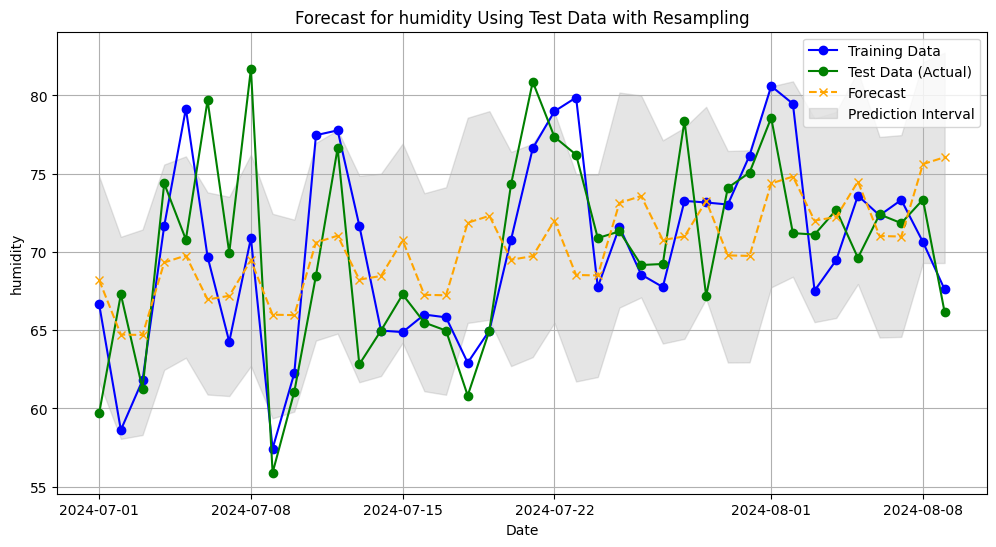


Forecast for humidity (Test Data):
           ds   humidity       yhat  yhat_lower  yhat_upper
0  2024-07-01  59.700000  68.199123   61.693976   74.829865
1  2024-07-02  67.287356  64.721546   58.054181   70.968039
2  2024-07-03  61.253333  64.692369   58.302663   71.432142
3  2024-07-04  74.375000  69.325971   62.465845   75.584326
4  2024-07-05  70.794521  69.770929   63.238470   76.105520
5  2024-07-06  79.691589  66.963703   60.887276   73.805587
6  2024-07-07  69.952830  67.195162   60.791090   73.522583
7  2024-07-08  81.701299  69.468371   62.708453   76.220646
8  2024-07-09  55.892308  65.990794   59.366906   72.436479
9  2024-07-10  61.058824  65.961618   59.797467   72.063155
10 2024-07-11  68.483146  70.595220   64.337480   76.965723
11 2024-07-12  76.632911  71.040178   64.781342   77.787058
12 2024-07-13  62.818182  68.232913   61.674184   74.866944
13 2024-07-14  64.974359  68.464332   62.071059   74.998471
14 2024-07-15  67.282051  70.737502   64.198203   76.927206
15 2

In [ ]:
forecast_with_test_data(
    df_train,
    df_test,
    target_variables=['WaterTemp', 'temperature', 'humidity']
)